<a href="https://colab.research.google.com/github/romenlaw/RL-playground/blob/main/rl_playground2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation

In [73]:
!pip install git+https://github.com/mimoralea/gym-walk#egg=gym-walk &>/dev/null
!pip install git+https://github.com/mimoralea/gym-aima#egg=gym-aima &>/dev/null

In [148]:
import gym
import gym_walk, gym_aima
import numpy as np
from pprint import pprint
from tqdm import tqdm_notebook as tqdm

from itertools import cycle, count
import itertools
from tabulate import tabulate

import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
SEEDS = (12, 34, 56, 78, 90)

%matplotlib inline

In [75]:
import warnings

warnings.filterwarnings('ignore')
# Ignore all DeprecationWarning
# warnings.filterwarnings('ignore', category=DeprecationWarning)
# warnings.filterwarnings('ignore', category=UserWarning)

## Utilities

In [76]:
# slightly modified from chapter 4: pi is a function instead of dict
def policy_evaluation(pi, P, gamma=1.0, theta=1e-10):
  prev_V = np.zeros(len(P)) # initialise value for each state to 0
  while True:
    V = np.zeros(len(P))
    for s in range(len(P)):
      # example of P[s]pi[s]: [(0.8, 0, 0.0, True), (0.0, 1, 0.0, False), (0.2, 2, 1.0, True)]
      for (prob, next_state, reward, done) in P[s][pi(s)]:
        # multiply by not done s.t. V(s)=0 if s is terminal state
        V[s] += prob * (reward + gamma * prev_V[next_state] * (not done) )
    # stop the while loop if values have converged
    if np.max(np.abs(prev_V - V)) < theta:
      break

    prev_V = V.copy()
  return V

def print_policy(pi, P, action_symbols=('<', 'v', '>', '^'), n_cols=4, title='Policy:'):
  print(title)
  arrs = {k:v for k,v in enumerate(action_symbols)}
  for s in range(len(P)):
    a = pi(s)
    print("| ", end="")
    if np.all([done for action in P[s].values() for _, _, _, done in action]):
        print("".rjust(9), end=" ")
    else:
        print(str(s).zfill(2), arrs[a].rjust(6), end=" ")
    if (s + 1) % n_cols == 0: print("|")

def print_state_value_function(V, P, n_cols=4, prec=3, title='State-value function:'):
  print(title)
  for s in range(len(P)):
    v = V[s]
    print("| ", end="")
    if np.all([done for action in P[s].values() for _, _, _, done in action]):
        print("".rjust(9), end=" ")
    else:
        print(str(s).zfill(2), '{}'.format(np.round(v, prec)).rjust(6), end=" ")
    if (s + 1) % n_cols == 0: print("|")

def print_action_value_function(Q,
                                optimal_Q=None,
                                action_symbols=('<', '>'),
                                prec=3,
                                title='Action-value function:'):
  vf_types=('',) if optimal_Q is None else ('', '*', 'er')
  headers = ['s',] + [' '.join(i) for i in list(itertools.product(vf_types, action_symbols))]
  print(title)
  states = np.arange(len(Q))[..., np.newaxis]
  arr = np.hstack((states, np.round(Q, prec)))
  if not (optimal_Q is None):
    arr = np.hstack((arr, np.round(optimal_Q, prec), np.round(optimal_Q-Q, prec)))
  print(tabulate(arr, headers, tablefmt="fancy_grid"))

def probability_success(env, pi, goal_state, n_episodes=100, max_steps=200):
  random.seed(123); np.random.seed(123) ; env.seed(123)
  results = []
  for _ in range(n_episodes):
    state, done, steps = env.reset(), False, 0
    while not done and steps < max_steps:
      state, _, done, h = env.step(pi(state))
      steps += 1
    results.append(state == goal_state)
  return np.sum(results)/len(results)*100

def mean_return(env, gamma, pi, n_episodes=100, max_steps=200):
  random.seed(123); np.random.seed(123) ; env.seed(123)
  results = []
  for _ in range(n_episodes):
    state, done, steps = env.reset(), False, 0
    results.append(0.0)
    while not done and steps < max_steps:
      state, reward, done, _ = env.step(pi(state))
      results[-1] += (gamma**steps * reward)
      steps += 1
  return np.mean(results)

def rmse(x, y, dp=4):
    return np.round(np.sqrt(np.mean((x - y)**2)), dp)

In [77]:
"""exponentially decaying schedule
this function allows you to calculate all the values for alpha for the full training process
"""
def decay_schedule(init_value, min_value,
                   decay_ratio, # determines how many episodes to use for decay
                   max_steps, # i.e. n_episodes in previous chapters
                   log_start=-2, log_base=10):
  assert min_value<=init_value, "min_value must be <= init_value"
  decay_steps = max(int(max_steps*decay_ratio), 1)
  rem_steps = max_steps - decay_steps # remaining steps (i.e. not used for decay)

  # calculate actual values of an inverse log curve ([::-1] reverse the order)
  values = np.logspace(start=log_start, stop=0,
                       num=decay_steps, # number of samples to generate
                       base=log_base,
                       endpoint=True # samples are inclusive of 'stop'
                       )[::-1]
  # print("reverse logspace: ", values)
  # normalise to between 0 and 1
  values = (values - values.min()) / (values.max() - values.min())
  # transform the points to lay between init_value and min_value
  values = min_value + (init_value - min_value) * values
  values = np.pad(values, (0, rem_steps), 'edge')
  return values


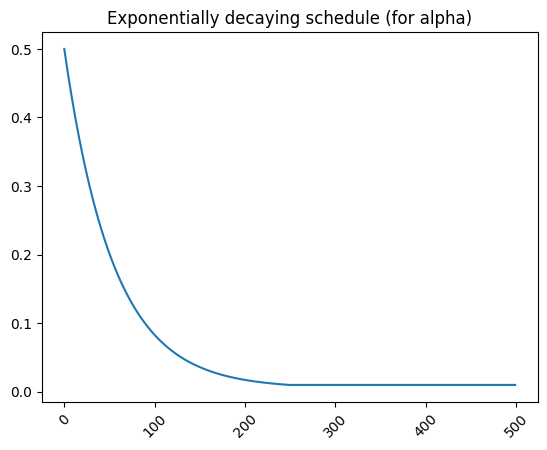

In [78]:
plt.plot(decay_schedule(0.5, 0.01, 0.5, 500))
plt.title('Exponentially decaying schedule (for alpha)')
plt.xticks(rotation=45)
plt.show()

In [79]:
"""Generate full trajectory
Running a policy and extracting the collection of experience tuples
(the trajectories) for offline processing.
"""
def generate_trajectory(pi, env, max_steps=200):
  done, trajectory =  False, []
  while not done:
    state = env.reset()
    trajectory = []
    t = 0
    while t<max_steps and not done: # max_steps allows truncation of long trajectory
      action = pi(state)
      next_state, reward, done, _ = env.step(action)
      experience = (state, action, reward, next_state, done)
      trajectory.append(experience)
      state = next_state

  return np.array(trajectory, np.object_)

## Plotting functions

In [80]:
def plot_value_function(title, V_track, V_true=None, log=False, limit_value=0.05, limit_items=5):
    np.random.seed(123)
    per_col = 25
    linecycler = cycle(["-","--",":","-."])
    legends = []

    valid_values = np.argwhere(V_track[-1] > limit_value).squeeze()
    items_idxs = np.random.choice(valid_values,
                                  min(len(valid_values), limit_items),
                                  replace=False)
    # draw the true values first
    if V_true is not None:
        for i, state in enumerate(V_track.T):
            if i not in items_idxs:
                continue
            if state[-1] < limit_value:
                continue

            label = 'v({})'.format(i)
            plt.axhline(y=V_true[i], color='k', linestyle='-', linewidth=1)
            plt.text(int(len(V_track)*1.02), V_true[i]+.01, label)

    # then the estimates
    for i, state in enumerate(V_track.T):
        if i not in items_idxs:
            continue
        if state[-1] < limit_value:
            continue
        line_type = next(linecycler)
        label = 'V({})'.format(i)
        p, = plt.plot(state, line_type, label=label, linewidth=3)
        legends.append(p)

    legends.reverse()

    ls = []
    for loc, idx in enumerate(range(0, len(legends), per_col)):
        subset = legends[idx:idx+per_col]
        l = plt.legend(subset, [p.get_label() for p in subset],
                       loc='center right', bbox_to_anchor=(1.25, 0.5))
        ls.append(l)
    [plt.gca().add_artist(l) for l in ls[:-1]]
    if log: plt.xscale('log')
    plt.title(title)
    plt.ylabel('State-value function')
    plt.xlabel('Episodes (log scale)' if log else 'Episodes')
    plt.show()

In [81]:
def plot_targets(targets, init_state, title):
    x = range(len(targets[init_state]))
    y = targets[init_state]

    label = 'v({})'.format(init_state)
    plt.axhline(y=V_true[init_state], color='k', linestyle='-', linewidth=1)
    plt.text(int(x[-1]*1.02), V_true[init_state]+.01, label)

    plt.scatter(x, y,
                c=np.array(targets[init_state]),
                cmap=plt.get_cmap('viridis'),
                alpha=0.4)
    plt.title(title)

    plt.ylabel('Target value')
    plt.xlabel('Estimate sequence number')
    plt.show()

## Random Walk Environment
Apply the Random Walk environment, using a policy of 'always left'.
```
 _________________________________
| H 0 | 1 | 2 | S 3 | 4 | 5 | G 6 |
 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
```
There are 7 states in this env, H=hole, G=Goal, S=Start

In [82]:
env = gym.make('RandomWalk-v0')
init_state = env.reset()
goal_state = 6
gamma = 1.0
n_episodes = 500
P = env.env.P

LEFT, RIGHT = range(2)
# always left policy:
pi = lambda s: {
    0:LEFT, 1:LEFT, 2:LEFT, 3:LEFT, 4:LEFT, 5:LEFT, 6:LEFT
}[s]
V_true = policy_evaluation(pi, P, gamma=gamma)

print_state_value_function(V_true, P, n_cols=7)
print()
print_policy(pi, P, action_symbols=('<', '>'), n_cols=7)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}.'.format(
    probability_success(env, pi, goal_state=goal_state),
    mean_return(env, gamma, pi)))


State-value function:
|           | 01  0.167 | 02  0.333 | 03    0.5 | 04  0.667 | 05  0.833 |           |

Policy:
|           | 01      < | 02      < | 03      < | 04      < | 05      < |           |
Reaches goal 44.00%. Obtains an average return of 0.4400.


In [83]:
pi

<function __main__.<lambda>(s)>

In [84]:
env.spec

EnvSpec(id='RandomWalk-v0', entry_point='gym_walk.envs:WalkEnv', reward_threshold=1.0, nondeterministic=True, max_episode_steps=100, order_enforce=True, autoreset=False, disable_env_checker=False, new_step_api=False, kwargs={'n_states': 5, 'p_stay': 0.0, 'p_backward': 0.5}, namespace=None, name='RandomWalk', version=0)

In [85]:
P

{0: {0: [(0.5, 0, 0.0, True), (0.0, 0, 0.0, True), (0.5, 0, 0.0, True)],
  1: [(0.5, 0, 0.0, True), (0.0, 0, 0.0, True), (0.5, 0, 0.0, True)]},
 1: {0: [(0.5, 0, 0.0, True), (0.0, 1, 0.0, False), (0.5, 2, 0.0, False)],
  1: [(0.5, 2, 0.0, False), (0.0, 1, 0.0, False), (0.5, 0, 0.0, True)]},
 2: {0: [(0.5, 1, 0.0, False), (0.0, 2, 0.0, False), (0.5, 3, 0.0, False)],
  1: [(0.5, 3, 0.0, False), (0.0, 2, 0.0, False), (0.5, 1, 0.0, False)]},
 3: {0: [(0.5, 2, 0.0, False), (0.0, 3, 0.0, False), (0.5, 4, 0.0, False)],
  1: [(0.5, 4, 0.0, False), (0.0, 3, 0.0, False), (0.5, 2, 0.0, False)]},
 4: {0: [(0.5, 3, 0.0, False), (0.0, 4, 0.0, False), (0.5, 5, 0.0, False)],
  1: [(0.5, 5, 0.0, False), (0.0, 4, 0.0, False), (0.5, 3, 0.0, False)]},
 5: {0: [(0.5, 4, 0.0, False), (0.0, 5, 0.0, False), (0.5, 6, 1.0, True)],
  1: [(0.5, 6, 1.0, True), (0.0, 5, 0.0, False), (0.5, 4, 0.0, False)]},
 6: {0: [(0.5, 6, 0.0, True), (0.0, 6, 0.0, True), (0.5, 6, 0.0, True)],
  1: [(0.5, 6, 0.0, True), (0.0, 6, 0

# Evaluating Agent's Behaviour (Prediction)

**Prediction Problem** - estimate the value of policies, without MDP, because it depends on future.




## First-Visit Monte-Carlo (FV MC)

**Monte-Carlo prediction** (MC) - run several episodes with the policy collecting hundreds of trajectories (i.e. taking actions from time step t till end of episode (at time step T), using $t:T$ as the notation below), and then calculate average for every state.

Monte-Carlo learning:
Action-value function is the expectation of returns.
$$v_\pi(S) = \mathbb E_\pi[G_{t:T}|S_t=s]$$
and Returns are total discounted rewards.
$$G_{t:T}=R_{t+1}+\gamma R_{t+2}+ \gamma R_{t+3} +... + \gamma^{T-1}R_T$$

So in MC, the first thing we do is sample the policy for a trajectory (i.e. from timestep t to T):
$$S_t,A_t,R_{t+1},S_{t+1},...,R_T,S_T \sim \pi_{t:T}$$
Then add up the per-state returns:
$$T_T(S_t)=T_T(S_t)+G_{t:T}$$
and increment a counter N:
$$N_T(S_T)=N_T(S_t)+1$$

We can estimate the expectation using empirical mean. So the estimated action-value function for a state is just the mean return for that state:
$$V_T(S_t)=\dfrac{T_T(S_t)}{N_T(S_t)}$$

As the count approach infinity, the estimate will approach the true value:
$$N(s) \to \infty , V(s) \to v_\pi(s)$$

Rewrite the above using recursion, so that we don't have to calculate sum of returns for all states (more efficient):
$$V_T(S_t)=V_{T-1}(S_t)+\dfrac{1}{N_T(S_t)}\left[G_{t:T}- V_{T-1}S(t)\right] $$
Replace the mean for a learning value that can be time dependent, or constant:
$$V_T(S_t)=V_{T-1}(S_t)+\alpha_t\left[\overbrace{\underbrace{G_{t:T}}_{\text { MC} \\ \text {target}}- V_{T-1}S(t)}^{\text {MC error}}\right] $$
Note that V is only calculated at the end of an episode, timestep T, because G depends on it.



## Every-Visit Monte-Carlo (EV MC)

One trajectory can visit a state multiple times. In FV MC we only calculate the return at the first visit of a state; for EV MC, we do this for every visit of the state.

IID = independent and identically distributed.

In FVMC, each trajectory is IID, so as we collect infinite samples, the estimate will converge to true value.

But in EVMC, trajectories are not IID. But EVMC has also been proven to converge to true value given infiniate samples.

In [86]:
"""Monte-Carlo Prediction
the function works for FVMC and EVMC
"""
def mc_prediction(pi, env,
                  gamma=1.0, # reward discount factor
                  init_alpha=0.5,
                  min_alpha=0.01,
                  alpha_decay_ratio=0.3, # use 30% of n_episodes to decay alpha
                  n_episodes=500,
                  max_steps=100, # stop trajectory if it gets too long
                  first_visit=True # flag for FVMC or EVMC
                  ):
  nS = env.observation_space.n # number of states
  # generates all discounts (gamma) at once, e.g. for gamma=0.99, it gives
  # 1, 0.99, 0.99**2, 0.99**3, etc. same as: [gamma**i for i in range(max_steps)]
  discounts = np.logspace(0, max_steps, num=max_steps, base=gamma, endpoint=False)
  alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)

  V = np.zeros(nS)
  # per episode copy of V for offline analysis
  V_track = np.zeros((n_episodes, nS))
  targets = {state:[] for state in range(nS)}

  for e in tqdm(range(n_episodes), leave=False):
    trajectory = generate_trajectory(pi, env, max_steps)
    visited = np.zeros(nS, dtype=np.bool_)
    for t, (state, _, reward, _, _) in enumerate(trajectory):
      if visited[state] and first_visit:
        continue
      # if this is first visit, or doing EVMC, then process current state.
      visited[state] = True
      n_steps = len(trajectory[t:]) # number of steps from t:T
      # calculate Return.
      G = np.sum(discounts[:n_steps] * trajectory[t:, 2]) # 2nd in the tuple is reward
      V[state] = V[state] + alphas[e] * (G - V[state]) # estimate value function

      targets[state].append(G)

    V_track[e] = V

  return V.copy(), V_track, targets

In [87]:
np.logspace(0, 10, 10, base=0.99, endpoint=False), [0.99**i for i in range(10)]

(array([1.        , 0.99      , 0.9801    , 0.970299  , 0.96059601,
        0.95099005, 0.94148015, 0.93206535, 0.92274469, 0.91351725]),
 [1.0,
  0.99,
  0.9801,
  0.970299,
  0.96059601,
  0.9509900498999999,
  0.941480149401,
  0.9320653479069899,
  0.9227446944279201,
  0.9135172474836408])

  0%|          | 0/500 [00:00<?, ?it/s]

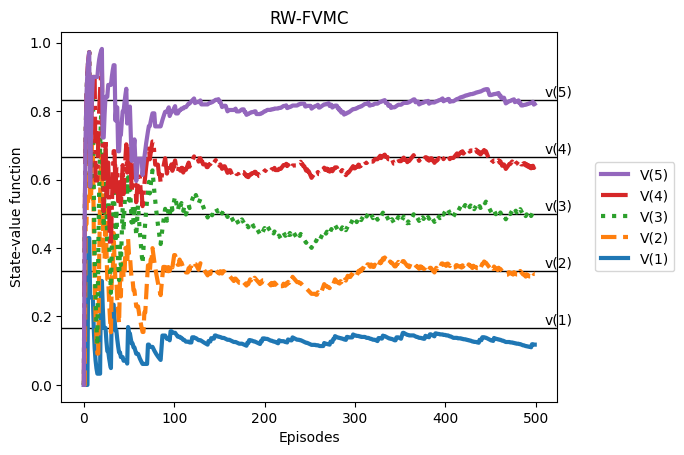

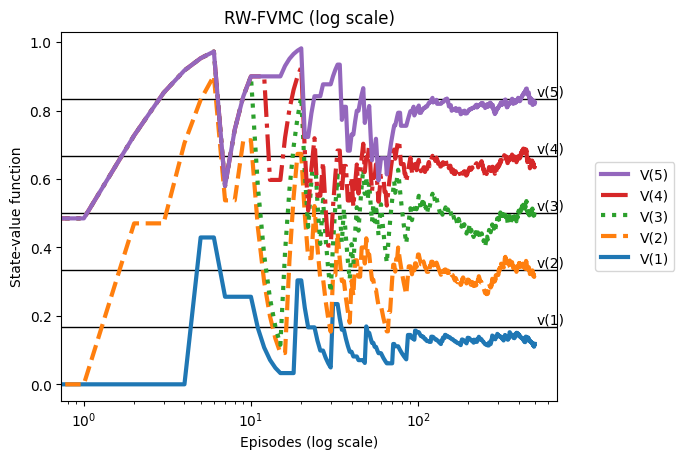

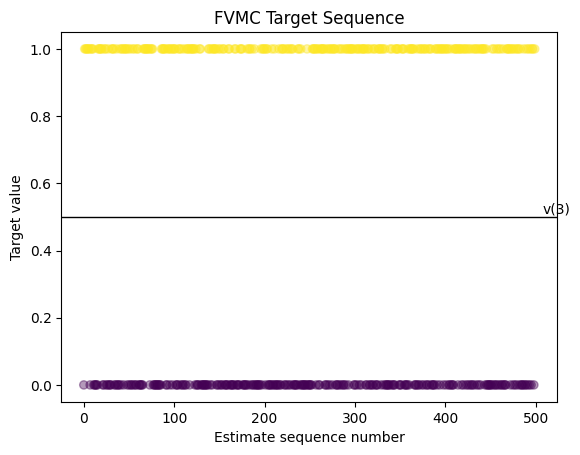

In [88]:
# testing it on random walk
env = gym.make('RandomWalk-v0')
V, V_track, targets = mc_prediction(pi, env)
plot_value_function("RW-FVMC", V_track, V_true)
plot_value_function("RW-FVMC (log scale)", V_track, V_true, log=True)
plot_targets(targets, init_state, 'FVMC Target Sequence')

  0%|          | 0/500 [00:00<?, ?it/s]

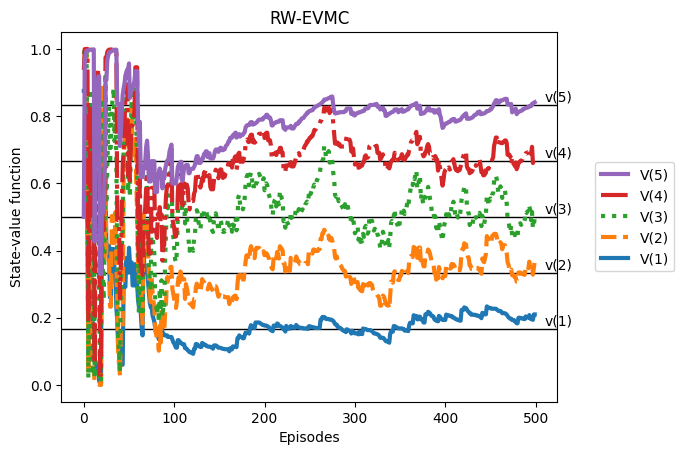

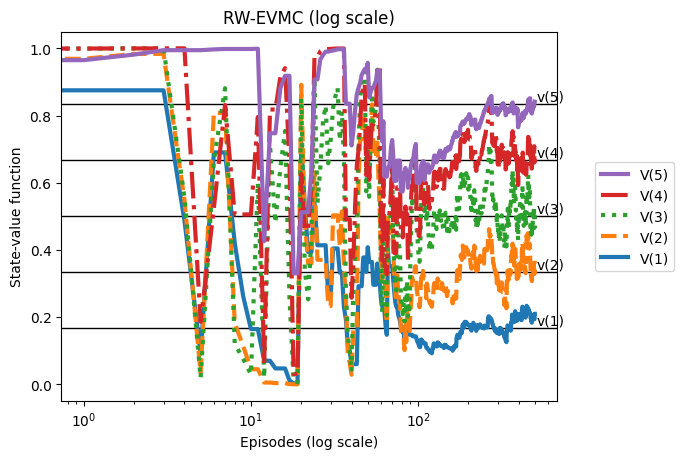

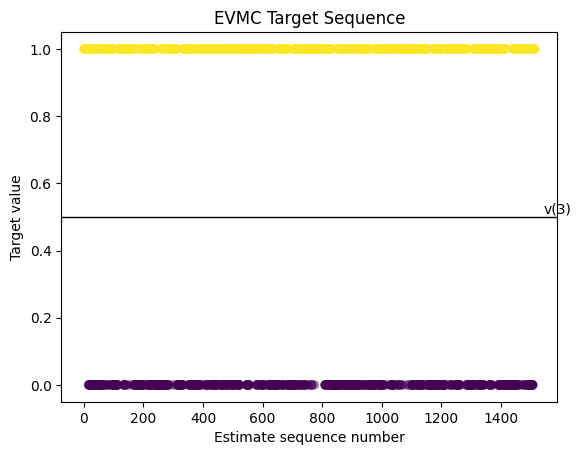

In [89]:
env = gym.make('RandomWalk-v0')
V, V_track, targets = mc_prediction(pi, env, first_visit=False)
plot_value_function("RW-EVMC", V_track, V_true)
plot_value_function("RW-EVMC (log scale)", V_track, V_true, log=True)
plot_targets(targets, init_state, 'EVMC Target Sequence')

The above plots show that
* MC is high variance - they jumpy around the true values. This is more so on EVMC.
* MC is unbiased - the target plots show either 1 or 0, i.e. the return at terminal states

## Temporal Difference learning (TD)

MC has to wait till end of episode to get the actual return $G_{t:T}$ to update state-value function estimate $V_T(S_t)$; it's good at convergence, *unbiased estimate*, but has *high variance* due to randomn events in trajectory.

TD is not MC because it can learn from imcomplete episode by using *one-step actual return* which is just the immediate reward $R_{t+1}$, then an *estimate of the return from next state onward* (t+1:T), i.e. $V(S_{t+1})$. That is,  $R_{t+1} + \gamma V(S_{t+1})$, which is called **TD Target**.

TD estimates $v_\pi (s)$ using an estimate of it, i.e. it 'bootstraps' - making estimate using an estimate, hence, a *biased estimation*. It also has much lower variance than MC because TD Target only depends on a single transition, a single reward, so there is much less randomness being accumulcatd. So TD learns much faster than MC.

TD learning equations:

We start from the definition of state-value function:
$$v_\pi(s)=\mathbb E[G_{t:T}|S_t=s]$$
From the definition of Return, we can re-arrange it into recursive form:
$$\begin{align}
G_{t:T}&=R_{t+1}+\gamma R_{t+2} + \gamma^2 R_{t+3} + ... + \gamma^{T-1} R_T \\
&= R_{t+1} + \gamma (R_{t+2} + \gamma R_{t+3} + ... + \gamma^{T-2}R_T) \\
&= R_{t+1} + \gamma G_{t+1:T}
\end{align}$$

We can use the same recursive definition to rewrite state-value function (because the Expectation of the Returns from the next state is simply the state-value function of the next state):
$$\begin{align}
v_\pi(s) &= \mathbb E[G_{t:T}|S_t=s] \\
&= \mathbb E[R_{t+1}+\gamma G_{t+1:T} | S_t=s] \\
&= \mathbb E[R_{t+1}+\gamma v_\pi(S_{t+1}) | S_t=s]
\end{align}$$

This means we can estimate the state-value function on every time step. We roll out a single interaction step:
$S_t, A_t, R_{t+1}, S_{t+2} \sim \pi_{t:t+1}$ and can obtain an estimation V(S) of true state-value function $v_\pi(S)$ a different way than MC:
$$V_{t+1}(S_t)=V_t(S_t)+\alpha_t\left[\overbrace{\underbrace{R_{t+1}+\gamma V_t(S_{t+1})}_{\text {TD target}}-V_t(S_t)}^{\text {TD error}}\right]$$
The key difference is we are now estimating $v_\pi(S_t)$ with an *estimate* of $v_\pi(S_{t+1})$.

In [90]:
def td(pi, env,
       gamma=1.0,
       init_alpha=0.5, min_alpha=0.01,
       alpha_decay_ratio=0.3, # use 30% of n_episodes to decay alpha
       n_episodes=500):
  nS = env.observation_space.n # number of states
  # initialise state-value function to zeros
  V = np.zeros(nS)
  V_track = np.zeros((n_episodes, nS))
  targets = {state:[] for state in range(nS)}
  alphas = decay_schedule(init_alpha, min_alpha,
                          alpha_decay_ratio, n_episodes)
  for e in tqdm(range(n_episodes), leave=False):
    state = env.reset()
    done = False
    while not done:
      # sameple the policy for the action to take in state 'state'
      action = pi(state)
      # use the action to interact with env... roll out the policy one-step
      next_state, reward, done, _ = env.step(action)

      # we can immediately estimate V
      td_target = reward + gamma * V[next_state] * (not done)
      td_error = td_target - V[state]
      V[state] = V[state] + alphas[e] * td_error

      targets[state].append(td_target)

      # don't forget to update state for next iteration
      state = next_state
    V_track[e] = V

  return V, V_track, targets

From the following plots we can see that TD is smoother than MC, but off-centered.

  0%|          | 0/500 [00:00<?, ?it/s]

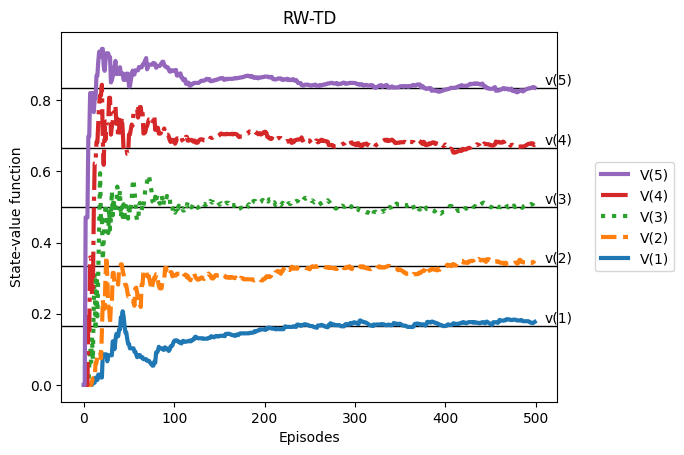

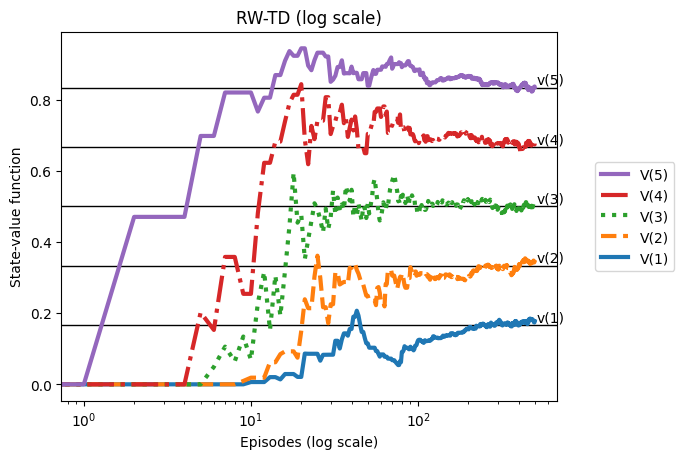

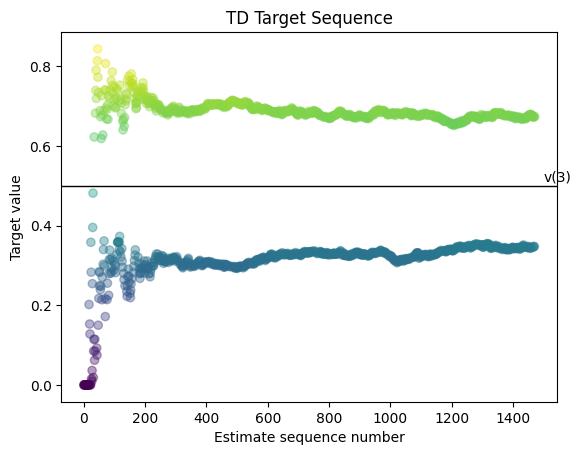

In [91]:
env = gym.make('RandomWalk-v0')
V, V_track, targets = td(pi, env)
plot_value_function("RW-TD", V_track, V_true)
plot_value_function("RW-TD (log scale)", V_track, V_true, log=True)
plot_targets(targets, init_state, 'TD Target Sequence')

From the above plots:
* TD state-value function plot shows less variance around the true values, comparing to MC. This shows TD is low variance
* TD Target plot jumps between approx 0.7 and 0.3 (instead of 1 and 0 at terminal states) because TD only estimate on next state. This shows TD is biased.


## n-Step TD Learning

improving estimates after a few steps - we wait n steps before we can update state-value function. N-step Temporal Difference equations:

$$S_t, A_t, R_{t+1}, S_{t+1}, ..., R_{t+n}, S_{t+n} \sim \pi_{t:t+n}
$$

n doesn't have to be ∞ like in MC, or 1 like in TD. You can pick value of n. In reality, n can be either n or less than n if it reaches terminal state before n.
$$G_{t+n}=\underbrace{R_{t+1}+\gamma R_{t+2} + ...+\gamma^{n-1} R_{t+n}}_{\text {partial return}} + \overbrace{\gamma^{n} V_{t+n-1}(S_{t+n})}^{\text {bootstrap value}}
$$

Update the value function after n steps:
$$V_{t+n}(S_{t+n})=V_{t+n-1}(S_{t})+\alpha_t\left[\overbrace{\underbrace{G_{t:t+n}}_{\text{n-step}\\ \text{target}}-V_{t+n-1}(S_t)}^{\text{n-step error}}\right]
$$



In [92]:
def ntd(pi, env,
        gamma=1.0,
        init_alpha=0.5, min_alpha=0.01,
        alpha_decay_ratio=0.3,
        n_step=3, # 3 steps and then bootstrap (or if we hit terminal state, no bootstrap since value of terminal state is 0)
        n_episodes=500):
  nS = env.observation_space.n # number of states
  # initialise state-value function
  V = np.zeros(nS)
  V_track = np.zeros((n_episodes, nS))

  alphas = decay_schedule(init_alpha, min_alpha,
                          alpha_decay_ratio, n_episodes)

  # calculate discounts in one-go. Unlike in MC where we go up to max_steps,
  # here we go up to n_step+1
  # e.g. for gamma=0.99, it gives 1, 0.99, 0.99**2, 0.99**3, until 0.99**n_step.
  # same as: [gamma**i for i in range(n_step+1)]
  discounts = np.logspace(start=0, stop=n_step+1, num=n_step+1, base=gamma, endpoint=False)
  targets = {state:[] for state in range(nS)}

  for e in tqdm(range(n_episodes), leave=False):
    # path holds partial trajectory: n-step most recent experiences
    state, done, path = env.reset(), False, [] # [] is not None
    while not done or path is not None:
      # the first expeerience of path is state whose value-function we're estimating
      # so once we've done estimating it, we move on to its next state, which is
      # the next element of path
      path = path[1:] # pop the 1st element of path, note: [][1:]=[]

      # interaction block: collect experience till hit terminal state (done) or
      # reached n_step
      while not done and len(path) < n_step:
        action = pi(state)
        next_state, reward, done, _ = env.step(action)
        experience = (state, reward, next_state, done)
        path.append(experience)
        state = next_state
        if done:
          break

      # this whole block is trying to estimate the value of the est_state
      n = len(path) # n could be n_step or less (when reached terminal state)
      est_state = path[0][0] # extract the state we are estimating
      # rewards is a vector of all rewards encountered from est_state till n
      # note that len(rewards)==len(path)==n
      rewards = np.array(path)[:, 1] # experience[1] is reward
      # vector of discounted rewards from est_action to n
      partial_return = discounts[:n] * rewards # dim is (n,)
      # boostrap value
      bs_val = discounts[-1] * V[next_state] * (not done) # it's scalar

      ntd_target = np.sum(np.append(partial_return, bs_val)) # G_t:t+n
      ntd_error = ntd_target - V[est_state]
      # update the state-value function
      V[est_state] = V[est_state] + alphas[e] * ntd_error

      targets[est_state].append(ntd_target)

      # here we set path to None to break out the episode loop, if path has
      # only one experience and 'done' of that experience is true
      if len(path)==1 and path[0][3]: # experience[3] is 'done'
        path = None

    V_track[e] = V
  return V, V_track, targets

In [93]:
np.logspace(0, 5, num=6, base=10, endpoint=False)

array([1.00000000e+00, 6.81292069e+00, 4.64158883e+01, 3.16227766e+02,
       2.15443469e+03, 1.46779927e+04])

In [94]:
[10**(i*5.0/6.0) for i in range(6)]

[1.0,
 6.812920690579613,
 46.4158883361278,
 316.22776601683796,
 2154.4346900318847,
 14677.992676220705]

In [95]:
np.logspace(0, 5, num=6, base=10, endpoint=True)

array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])

In [96]:
np.logspace(0, 6, num=6, base=10, endpoint=False)

array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])

From the following plot we can see:
* n-step curves are more like MC, noise but centered
* the more steps, it becomes more like MC

  0%|          | 0/500 [00:00<?, ?it/s]

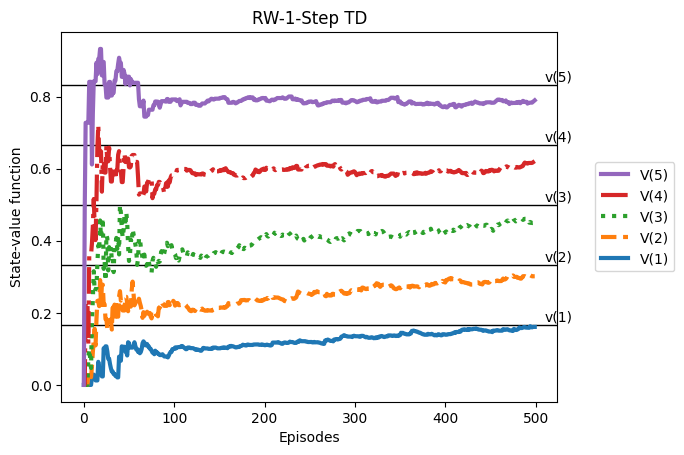

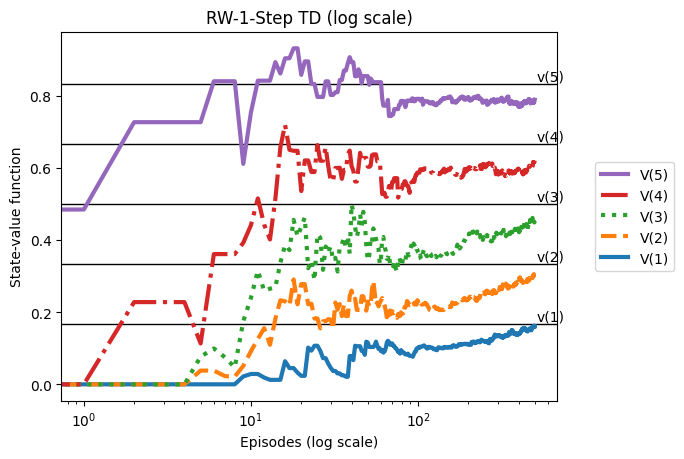

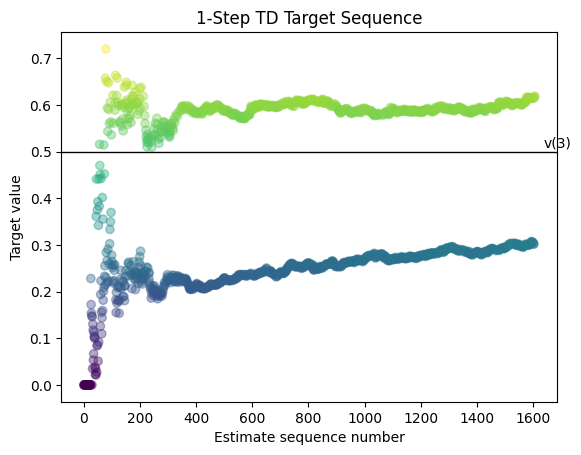

In [97]:
env = gym.make('RandomWalk-v0')
V, V_track, targets = ntd(pi, env, n_step=1)
plot_value_function("RW-1-Step TD", V_track, V_true)
plot_value_function("RW-1-Step TD (log scale)", V_track, V_true, log=True)
plot_targets(targets, init_state, '1-Step TD Target Sequence')

  0%|          | 0/500 [00:00<?, ?it/s]

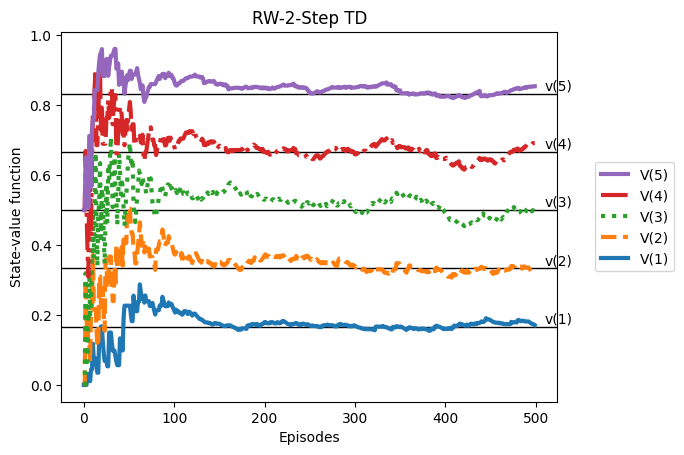

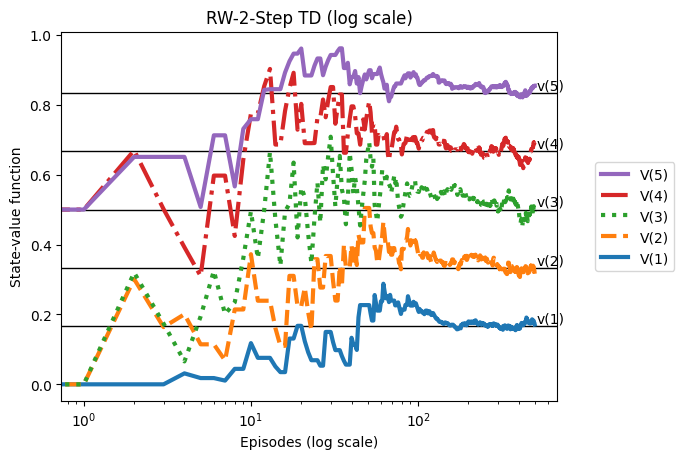

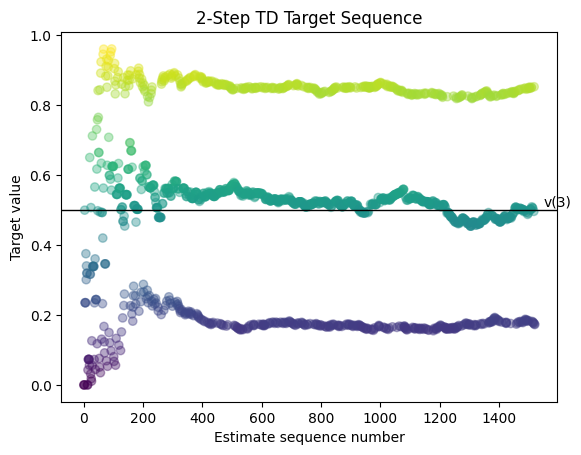

In [98]:
env = gym.make('RandomWalk-v0')
V, V_track, targets = ntd(pi, env, n_step=2)
plot_value_function("RW-2-Step TD", V_track, V_true)
plot_value_function("RW-2-Step TD (log scale)", V_track, V_true, log=True)
plot_targets(targets, init_state, '2-Step TD Target Sequence')

In [99]:
targets[6]

[]

  0%|          | 0/500 [00:00<?, ?it/s]

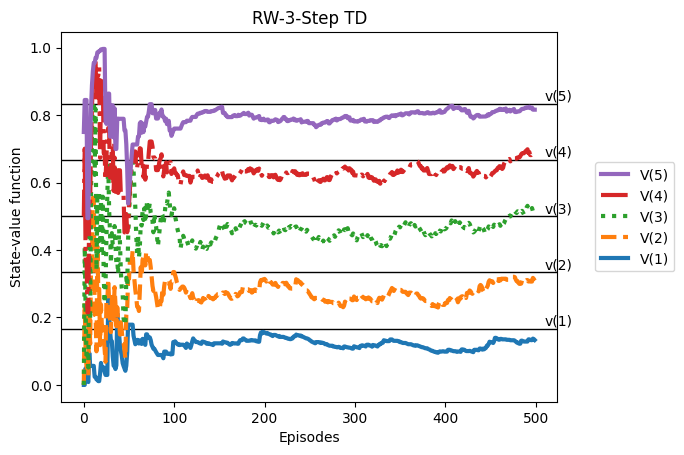

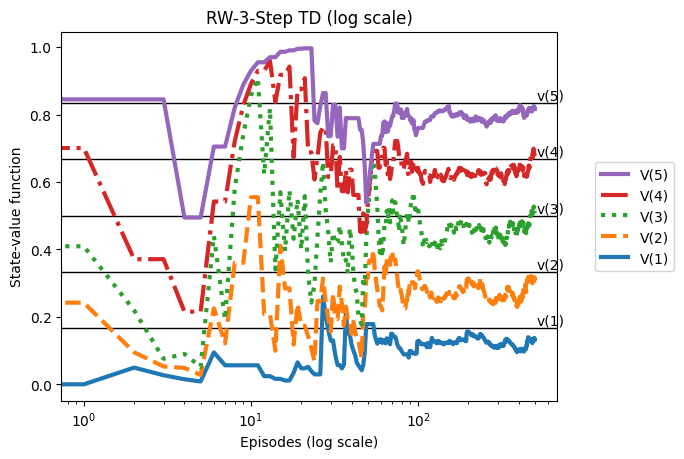

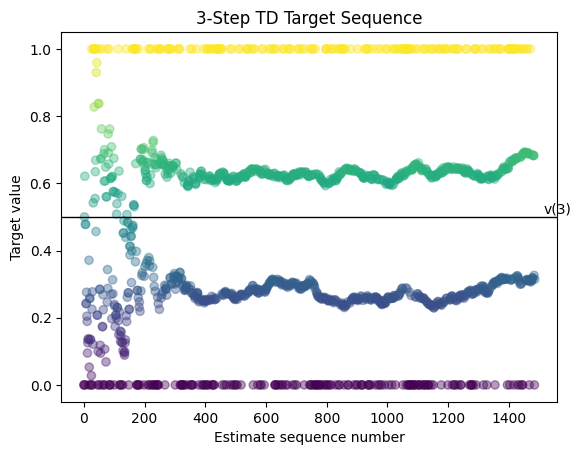

In [100]:
env = gym.make('RandomWalk-v0')
V, V_track, targets = ntd(pi, env, n_step=3)
plot_value_function("RW-3-Step TD", V_track, V_true)
plot_value_function("RW-3-Step TD (log scale)", V_track, V_true, log=True)
plot_targets(targets, init_state, '3-Step TD Target Sequence')

  0%|          | 0/500 [00:00<?, ?it/s]

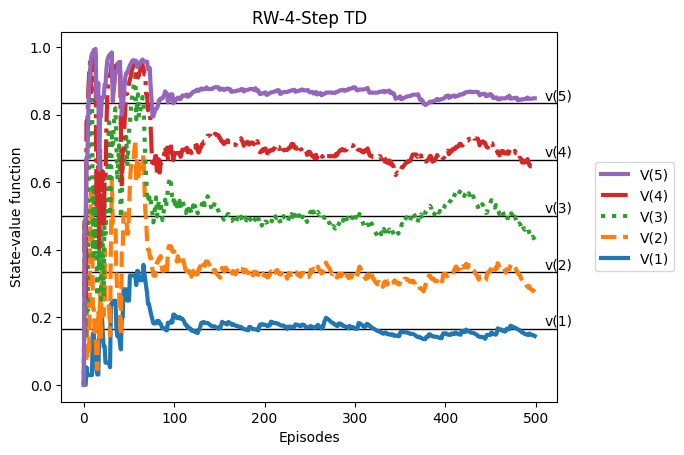

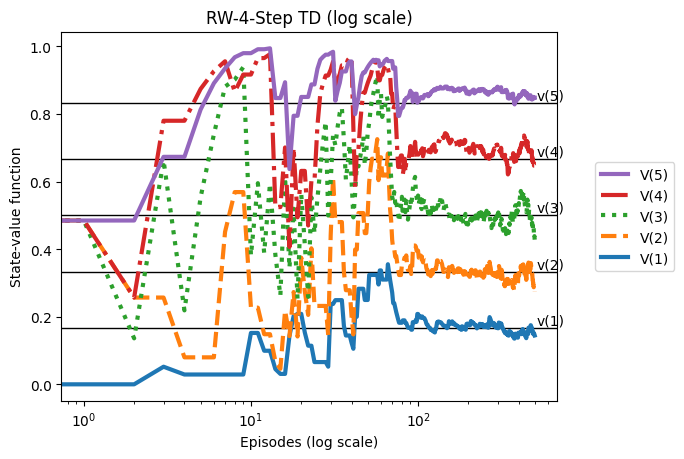

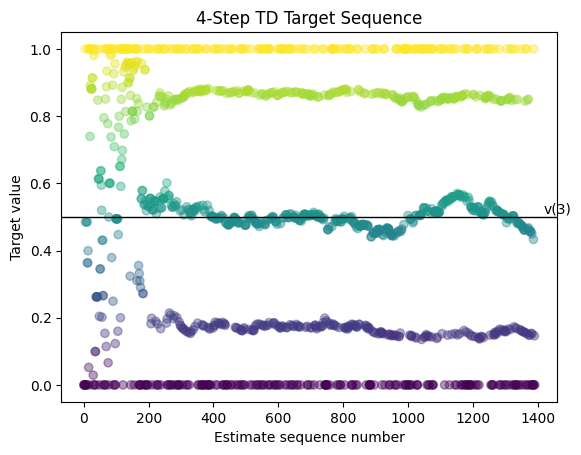

In [101]:
env = gym.make('RandomWalk-v0')
V, V_track, targets = ntd(pi, env, n_step=4)
plot_value_function("RW-4-Step TD", V_track, V_true)
plot_value_function("RW-4-Step TD (log scale)", V_track, V_true, log=True)
plot_targets(targets, init_state, '4-Step TD Target Sequence')

  0%|          | 0/500 [00:00<?, ?it/s]

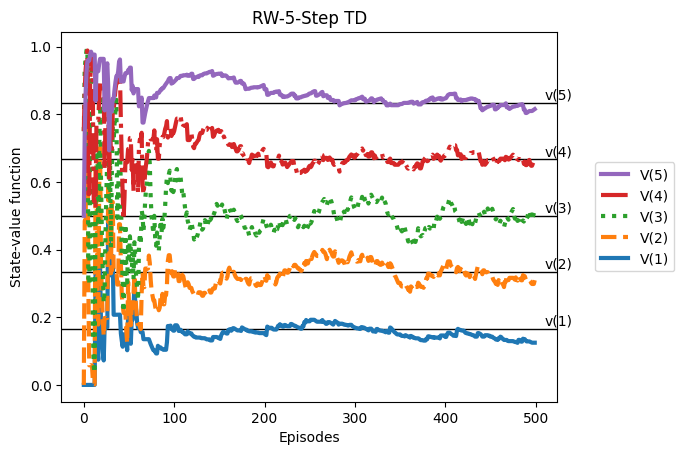

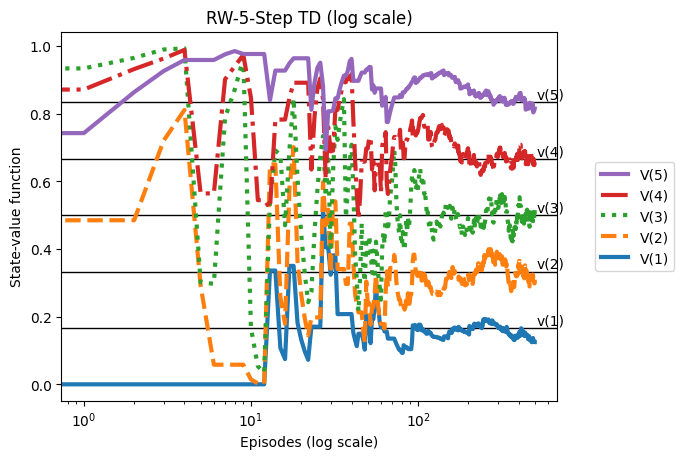

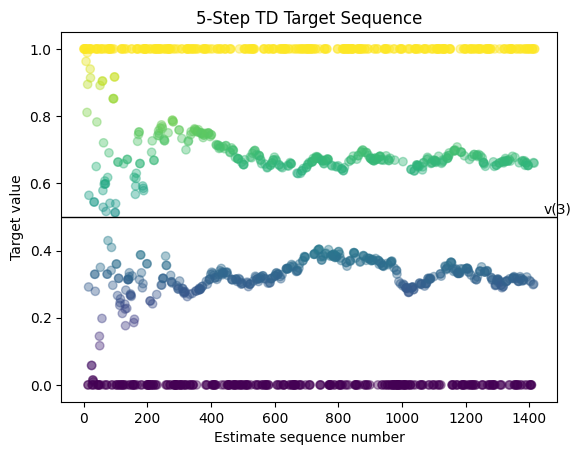

In [102]:
env = gym.make('RandomWalk-v0')
V, V_track, targets = ntd(pi, env, n_step=5)
plot_value_function("RW-5-Step TD", V_track, V_true)
plot_value_function("RW-5-Step TD (log scale)", V_track, V_true, log=True)
plot_targets(targets, init_state, '5-Step TD Target Sequence')

  0%|          | 0/500 [00:00<?, ?it/s]

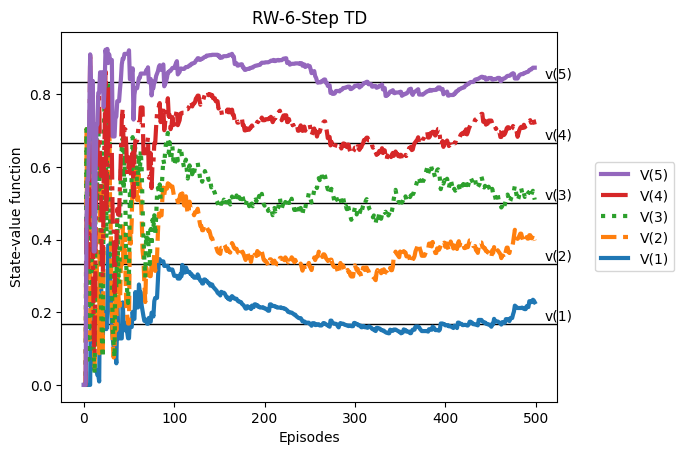

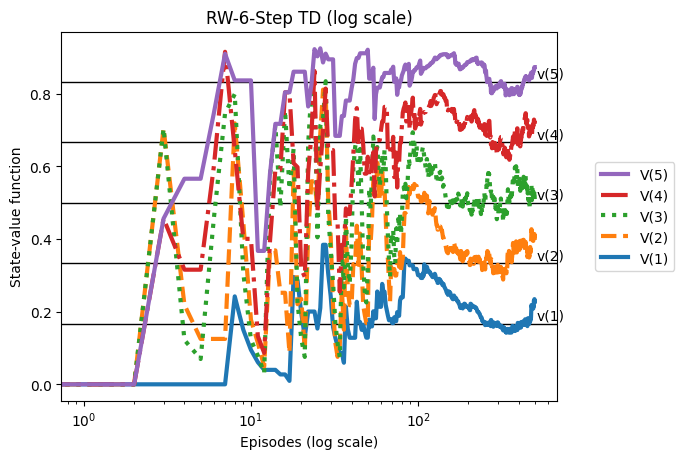

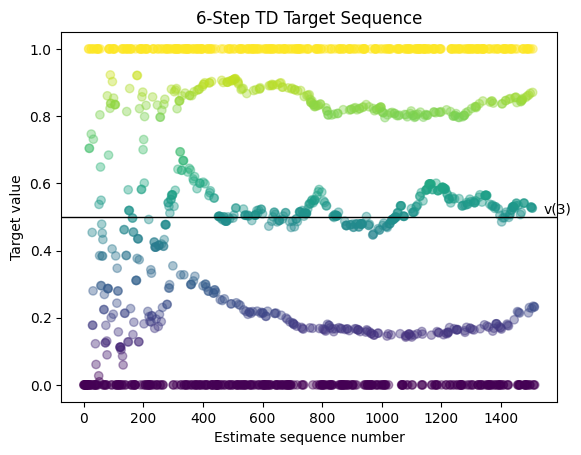

In [103]:
env = gym.make('RandomWalk-v0')
V, V_track, targets = ntd(pi, env, n_step=6)
plot_value_function("RW-6-Step TD", V_track, V_true)
plot_value_function("RW-6-Step TD (log scale)", V_track, V_true, log=True)
plot_targets(targets, init_state, '6-Step TD Target Sequence')

  0%|          | 0/500 [00:00<?, ?it/s]

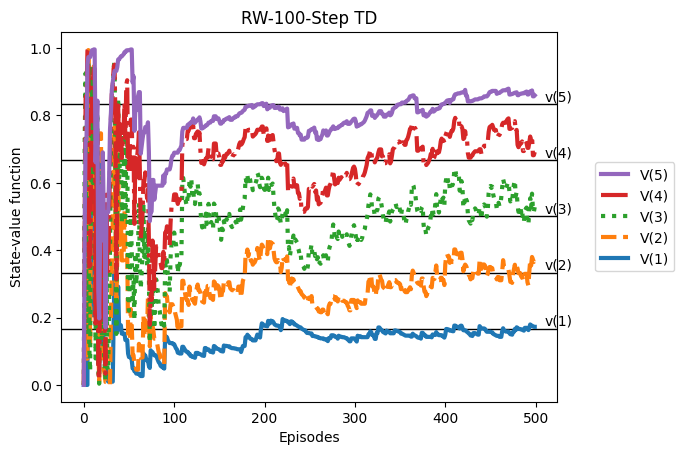

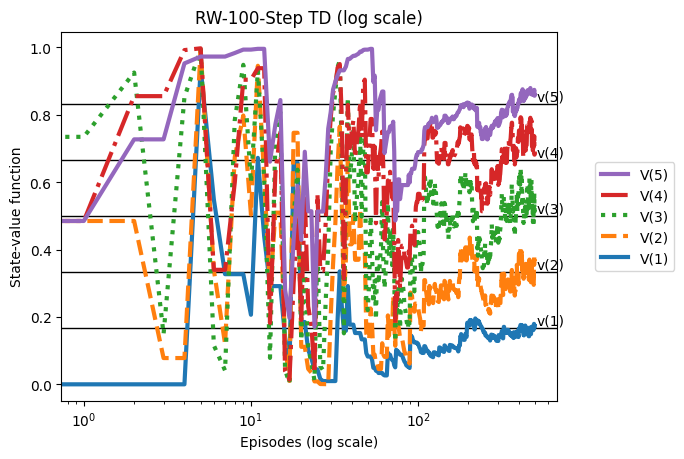

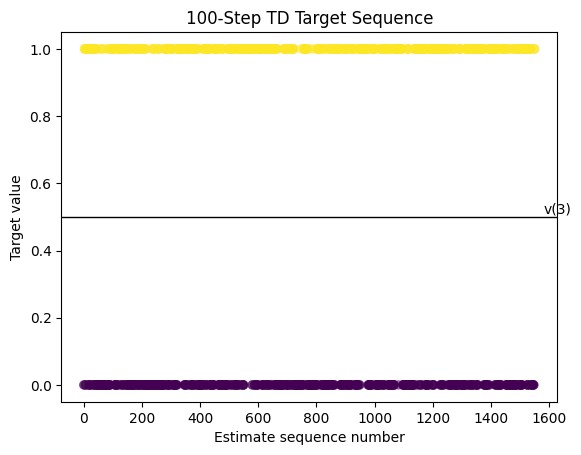

In [104]:
n=100
env = gym.make('RandomWalk-v0')
V, V_track, targets = ntd(pi, env, n_step=n)
plot_value_function(f"RW-{n}-Step TD", V_track, V_true)
plot_value_function(f"RW-{n}-Step TD (log scale)", V_track, V_true, log=True)
plot_targets(targets, init_state, f'{n}-Step TD Target Sequence')

## Forward-View TD(λ)

Improving estimates of all visited states.

It combines multiple n-steps into one update by introducing a weight λ. In FV TD(λ), agent will have to wait till end of an episode before updating.

The equations:
Calculating the n-step *λ-return*: note that when λ=1, it's MC; when λ=0, it's n-step TD.
$$G^\lambda_{t:T}=\underbrace{(1-\lambda)\sum_{n=1}^{T-t-1}λ^{n-1}G_{t:t+n}}_{\text {sum of weighted returns} \\ \text{from 1-step to T-1 steps}} + \underbrace{\lambda^{T-t-1} G_{t:T}}_{\text {weighted} \\ \text {final return (T)}}
$$
Weighted final return (T): because T is variable, we need to weigh the actual return with normalising value s.t. all weight add up to 1.

Unpacking the above returns for each n-step:

$G_{t:t+1}=R_{t+1} + \gamma V_{t}(S_{t+1}) $ for 1-step return and weigh this by $(1-\lambda)$

$
G_{t:t+2} = R_{t+1} + \gamma R_{t+2} + \gamma^2V_{t+1}(S_{t+2})$ for 2-step return and weigh this by $(1-\lambda)\lambda$

$
G_{t:t+3}=R_{t+1}+\gamma R_{t+2} + \gamma^2R_{t+3} + \gamma^3V_{t+2}(S_{t+3})$ for 3-step return and weigh it by $(1-\lambda)\lambda^2$

$
G_{t:t+n}=R_{t+1}+\gamma R_{t+2} + \gamma^2R_{t+3} +...+\gamma^nV_{t+n-1}(S_{t+n})$ ... , do this for all n-steps and weigh it by $(1-\lambda)\lambda^{n-1}$

Until the agent reaches a terminal state
$
G_{t:T}=R_{t+1}+\gamma R_{t+2} + \gamma^2R_{t+3}+...+\gamma^{T-1}R_{T}
$ and weigh this by $\lambda^{T-t-1}$

Note that we must sample the entire trajectory before we can calculate these values.
$$S_t, A_t, R_{t+1}, S_{t+1},...,R_T, S_T \sim \pi_{t:T}$$

Hence, V will become available at time T (because λ-return is only available at T):
$$V_T(S_T)=V{T-1}(S_t)+\alpha_t\left[\overbrace{\underbrace{G_{t:T}}_{\lambda\text {-return}}^\lambda - V_{T-1}S(t)}^{\lambda \text{-error}}\right]
$$

So it's similar to MC in terms of time step. But we can get lower-variance targets if we are willing to give up unbiasedness.

## (Backward-View) TD(λ)

BV TD(λ), or just TD(λ) for short can still tune the variance/bias trade-off in addition to apply *updates at every time step*, just like TD. The mechanism used by TD(λ) is **eligibility traces** - a memory vector that keeps track of recently visited states.

1. for every episode, we set the eligibility vector to 0 ⟼ $E_0=0$
2. then, we interact with the environment one cycle. ⟼ $S_t, A_t, R_{t+1}, S_{t+1} \sim \pi_{t:t+1}$
3. when you encounter a state S_t, make it eligible for an update... i.e. increment its eligibility by 1 ⟼ $E_t(S_t) = E_t(S_t)+1$
4. We then calculate the TD-error ⟼ $\delta^{TD}_{t:t+1}(S_t)=\underbrace{R_{t+1}+\gamma V_t(S_{t+1})}_{\text {TD target}}-V_t(S_t)$
5. however, unlike before, we estimate the state-value function V every time step, for all states (by multiplying with the eligibility vector, which is for all states). ⟼ $V_{t+1}=V_t+\alpha_t \underbrace{\delta^{TD}_{t:t+1}(S_t)}_{\text {TD error}}E_t$
6. finally, decay the eligibility ⟼ $E_{t+1}=E_t\gamma\lambda$

Again, note that when λ=1, it's MC; when λ=0, it's TD. Therefore
* TD(1) is assumed equal to MC
* TD is also referred as TD(0)
* a more recent method called **True Online TD(λ)** achieves perfect equivalence of TD(0) with TD, TD(1) with MC

In [105]:
def td_lambda(pi, env,
              gamma=1.0,
              init_alpha=0.5, min_alpha=0.01,
              alpha_decay_ratio=0.3, # use 30% of episodes to decay alpha
              lambda_=0.3,
              n_episodes=500):
  nS = env.observation_space.n # number of states
  V = np.zeros(nS)
  V_track = np.zeros((n_episodes, nS))
  E = np.zeros(nS) # eligibility trace vector
  alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
  targets = {state:[] for state in range(nS)}

  for e in tqdm(range(n_episodes), leave=False):
    E.fill(0) # reset E to zero for every new episode
    state = env.reset()
    done = False

    while not done: # time step loop
      # interact with environment one step, get the experience tuple
      action = pi(state)
      next_state, reward, done, _ = env.step(action)

      # use the experience to calculate TD error
      td_target = reward + gamma * V[next_state] * (not done)
      td_error = td_target - V[state]
      targets[state].append( td_target )

      E[state] += 1 # increment E for state visited
      # update action-value function V
      V = V + alphas[e] * td_error * E
      E = E * gamma * lambda_ # decay E

      state = next_state

    V_track[e] = V
  return V, V_track, targets


From the following plots, we can see that
* TD(λ) is a bit more like TD: smoother but off-centered
* when λ=0, it's TD
* when λ=1, it's like MC: noise but centered; but the target sequence is not like MC (but rather like offlien MC)

  0%|          | 0/500 [00:00<?, ?it/s]

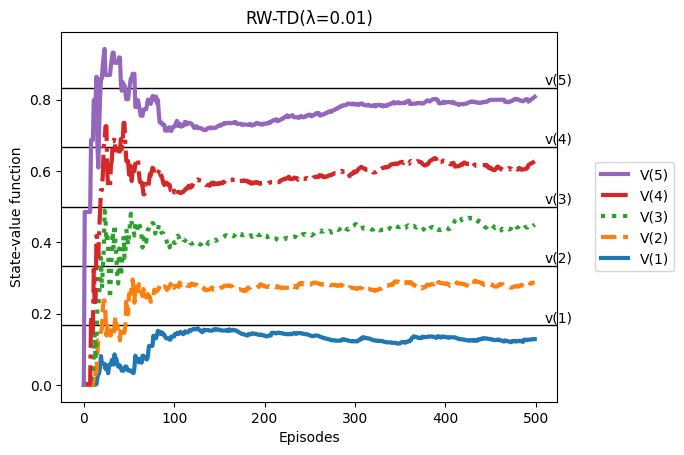

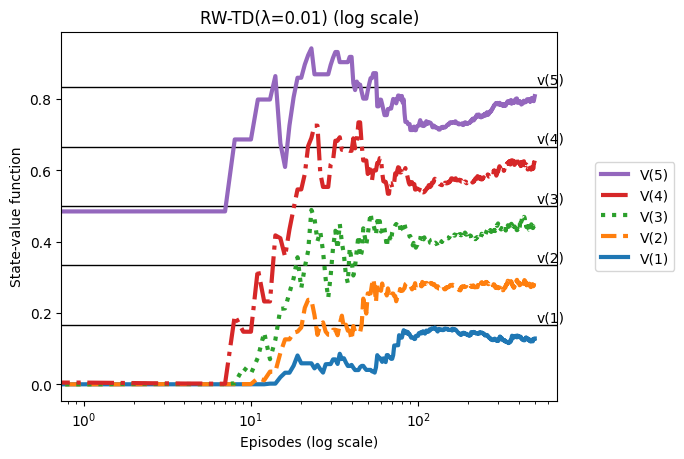

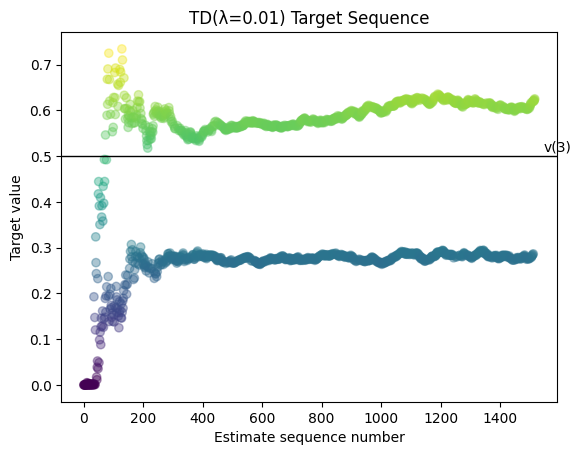

In [106]:
lambda_=0.01
env = gym.make('RandomWalk-v0')
V, V_track, targets = td_lambda(pi, env, lambda_=lambda_)
plot_value_function(f"RW-TD(λ={lambda_})", V_track, V_true)
plot_value_function(f"RW-TD(λ={lambda_}) (log scale)", V_track, V_true, log=True)
plot_targets(targets, init_state, f'TD(λ={lambda_}) Target Sequence')

  0%|          | 0/500 [00:00<?, ?it/s]

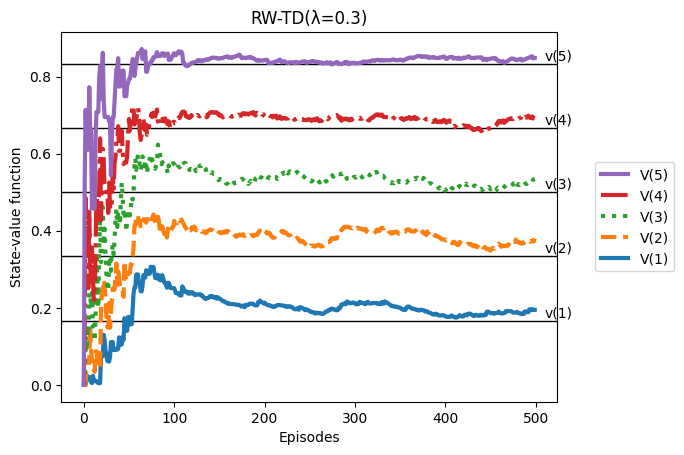

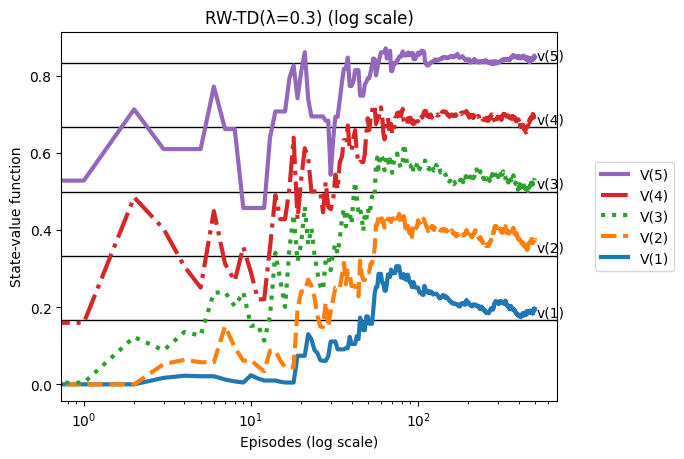

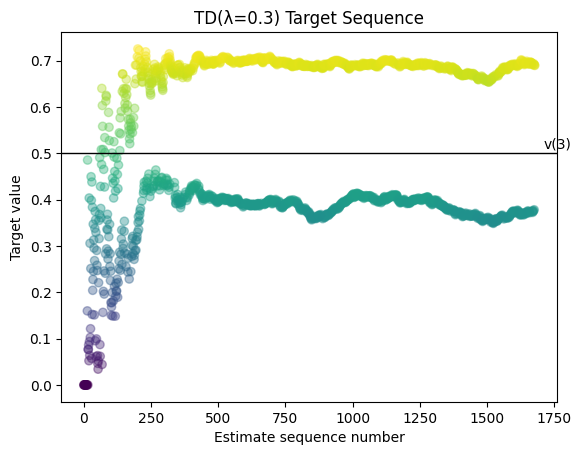

In [107]:
lambda_=0.3
env = gym.make('RandomWalk-v0')
V, V_track, targets = td_lambda(pi, env, lambda_=lambda_)
plot_value_function(f"RW-TD(λ={lambda_})", V_track, V_true)
plot_value_function(f"RW-TD(λ={lambda_}) (log scale)", V_track, V_true, log=True)
plot_targets(targets, init_state, f'TD(λ={lambda_}) Target Sequence')

  0%|          | 0/500 [00:00<?, ?it/s]

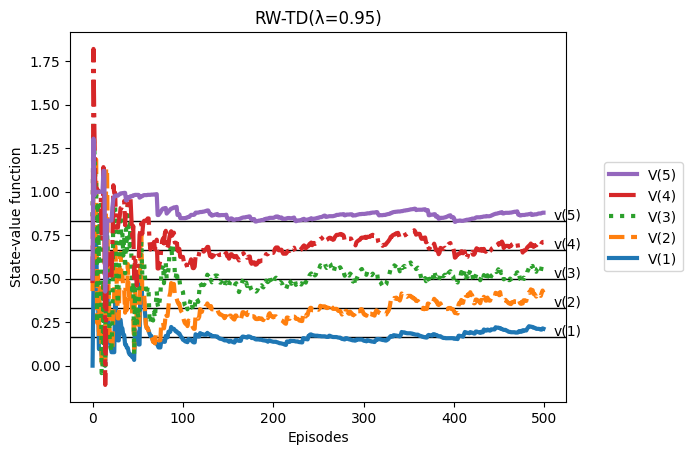

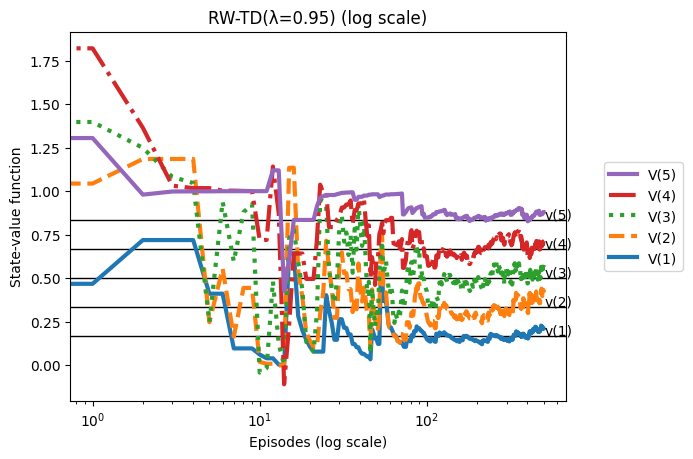

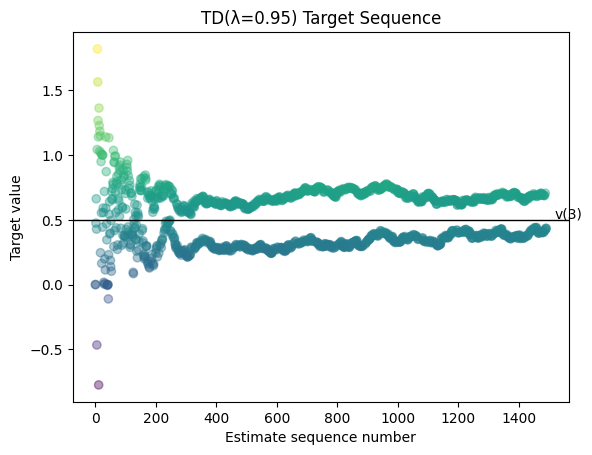

In [108]:
lambda_=0.95
env = gym.make('RandomWalk-v0')
V, V_track, targets = td_lambda(pi, env, lambda_=lambda_)
plot_value_function(f"RW-TD(λ={lambda_})", V_track, V_true)
plot_value_function(f"RW-TD(λ={lambda_}) (log scale)", V_track, V_true, log=True)
plot_targets(targets, init_state, f'TD(λ={lambda_}) Target Sequence')

## Frozen Lake and Sample Policy

See https://www.gymlibrary.dev/environments/toy_text/frozen_lake/ for environment details.




In [109]:
env = gym.make('FrozenLake-v1')
init_state = env.reset()
goal_state = 15
gamma = 0.99
n_episodes = 2500
P = env.env.P

LEFT, DOWN, RIGHT, UP = range(4)
pi = lambda s: {
  0:LEFT,   1:UP,     2:UP,    3:UP,
  4:LEFT,   5:LEFT,   6:LEFT,  7:LEFT,
  8:UP,     9:DOWN,  10:LEFT, 11:LEFT,
  12:LEFT, 13:RIGHT, 14:DOWN, 15:LEFT
}[s]
V_true = policy_evaluation(pi, P, gamma=gamma)

print_state_value_function(V_true, P)
print()

print_policy(pi, P)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}.'.format(
  probability_success(env, pi, goal_state=goal_state),
  mean_return(env, gamma, pi)))

State-value function:
| 00  0.542 | 01  0.499 | 02  0.471 | 03  0.457 |
| 04  0.558 |           | 06  0.358 |           |
| 08  0.592 | 09  0.643 | 10  0.615 |           |
|           | 13  0.742 | 14  0.863 |           |

Policy:
| 00      < | 01      ^ | 02      ^ | 03      ^ |
| 04      < |           | 06      < |           |
| 08      ^ | 09      v | 10      < |           |
|           | 13      > | 14      v |           |
Reaches goal 69.00%. Obtains an average return of 0.4808.


### FVMC

In [110]:
V_fvmcs, V_track_fvmcs = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_fvmc, V_track_fvmc, targets_fvmc = mc_prediction(pi, env, gamma=gamma, n_episodes=n_episodes)
    V_fvmcs.append(V_fvmc) ; V_track_fvmcs.append(V_track_fvmc)
V_fvmc, V_track_fvmc = np.mean(V_fvmcs, axis=0), np.mean(V_track_fvmcs, axis=0)
del V_fvmcs ; del V_track_fvmcs

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

In [111]:
print_state_value_function(V_fvmc, P)
print()
print_state_value_function(V_fvmc - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_fvmc, V_true))

State-value function:
| 00  0.518 | 01  0.359 | 02  0.336 | 03   0.31 |
| 04  0.534 |           | 06  0.311 |           |
| 08  0.568 | 09  0.612 | 10  0.576 |           |
|           | 13  0.696 | 14  0.835 |           |

State-value function errors:
| 00 -0.024 | 01  -0.14 | 02 -0.134 | 03 -0.146 |
| 04 -0.025 |           | 06 -0.048 |           |
| 08 -0.024 | 09 -0.031 | 10 -0.039 |           |
|           | 13 -0.045 | 14 -0.027 |           |
RMSE: 0.0654


### EVMC

In [112]:
V_evmcs, V_track_evmcs = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_evmc, V_track_evmc, targets_evmc = mc_prediction(pi, env, gamma=gamma, n_episodes=n_episodes, first_visit=False)
    V_evmcs.append(V_evmc) ; V_track_evmcs.append(V_track_evmc)
V_evmc, V_track_evmc = np.mean(V_evmcs, axis=0), np.mean(V_track_evmcs, axis=0)
del V_evmcs ; del V_track_evmcs

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

In [113]:
print_state_value_function(V_evmc, P)
print()
print_state_value_function(V_evmc - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_evmc, V_true))

State-value function:
| 00  0.487 | 01  0.303 | 02  0.293 | 03  0.283 |
| 04  0.497 |           | 06  0.302 |           |
| 08  0.518 | 09  0.575 | 10  0.555 |           |
|           | 13  0.678 | 14  0.815 |           |

State-value function errors:
| 00 -0.055 | 01 -0.196 | 02 -0.177 | 03 -0.174 |
| 04 -0.061 |           | 06 -0.056 |           |
| 08 -0.074 | 09 -0.068 | 10  -0.06 |           |
|           | 13 -0.064 | 14 -0.048 |           |
RMSE: 0.0901


### TD

In [114]:
V_tds, V_track_tds = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_td, V_track_td, targets_td = td(pi, env, gamma=gamma, n_episodes=n_episodes)
    V_tds.append(V_td) ; V_track_tds.append(V_track_td)
V_td, V_track_td = np.mean(V_tds, axis=0), np.mean(V_track_tds, axis=0)
del V_tds ; del V_track_tds

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

In [115]:
print_state_value_function(V_td, P)
print()
print_state_value_function(V_td - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_td, V_true))

State-value function:
| 00  0.501 | 01  0.454 | 02  0.416 | 03  0.398 |
| 04   0.52 |           | 06  0.337 |           |
| 08   0.56 | 09  0.616 | 10    0.6 |           |
|           | 13  0.712 | 14  0.841 |           |

State-value function errors:
| 00 -0.041 | 01 -0.045 | 02 -0.054 | 03 -0.059 |
| 04 -0.038 |           | 06 -0.021 |           |
| 08 -0.031 | 09 -0.027 | 10 -0.015 |           |
|           | 13  -0.03 | 14 -0.022 |           |
RMSE: 0.031


### n-Step TD

In [116]:
V_ntds, V_track_ntds = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_ntd, V_track_ntd, targets_ntd = ntd(pi, env, gamma=gamma, n_episodes=n_episodes)
    V_ntds.append(V_ntd) ; V_track_ntds.append(V_track_ntd)
V_ntd, V_track_ntd = np.mean(V_ntds, axis=0), np.mean(V_track_ntds, axis=0)
del V_ntds ; del V_track_ntds

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

In [117]:
print_state_value_function(V_ntd, P)
print()
print_state_value_function(V_ntd - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_ntd, V_true))

State-value function:
| 00  0.497 | 01  0.454 | 02  0.418 | 03  0.399 |
| 04  0.518 |           | 06  0.336 |           |
| 08  0.557 | 09  0.613 | 10  0.595 |           |
|           | 13  0.711 | 14  0.836 |           |

State-value function errors:
| 00 -0.045 | 01 -0.045 | 02 -0.053 | 03 -0.058 |
| 04 -0.041 |           | 06 -0.022 |           |
| 08 -0.035 | 09  -0.03 | 10  -0.02 |           |
|           | 13 -0.031 | 14 -0.027 |           |
RMSE: 0.0321


### TD(λ)

In [118]:
V_tdls, V_track_tdls = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_tdl, V_track_tdl, targets_tdl = td_lambda(pi, env, gamma=gamma, n_episodes=n_episodes)
    V_tdls.append(V_tdl) ; V_track_tdls.append(V_track_tdl)
V_tdl, V_track_tdl = np.mean(V_tdls, axis=0), np.mean(V_track_tdls, axis=0)
del V_tdls ; del V_track_tdls

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

In [119]:
print_state_value_function(V_tdl, P)
print()
print_state_value_function(V_tdl - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_tdl, V_true))

State-value function:
| 00  0.501 | 01  0.456 | 02  0.419 | 03  0.402 |
| 04  0.521 |           | 06  0.338 |           |
| 08   0.56 | 09  0.616 | 10    0.6 |           |
|           | 13  0.712 | 14   0.84 |           |

State-value function errors:
| 00 -0.041 | 01 -0.043 | 02 -0.051 | 03 -0.055 |
| 04 -0.038 |           | 06  -0.02 |           |
| 08 -0.032 | 09 -0.027 | 10 -0.015 |           |
|           | 13  -0.03 | 14 -0.023 |           |
RMSE: 0.0301


### Plot state-value function estimation

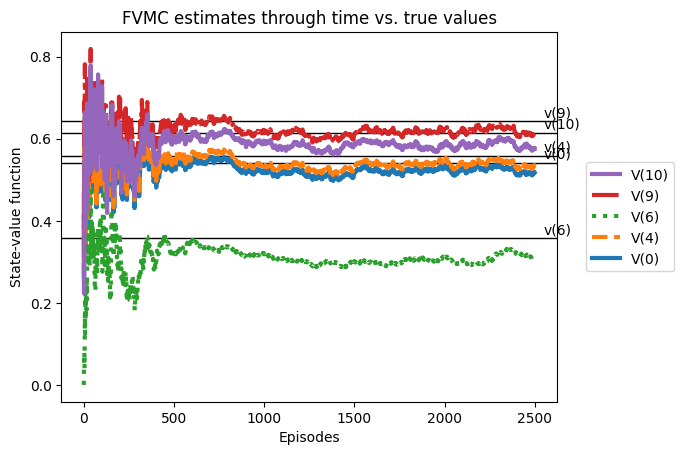

In [120]:
plot_value_function('FVMC estimates through time vs. true values', V_track_fvmc, V_true, log=False)

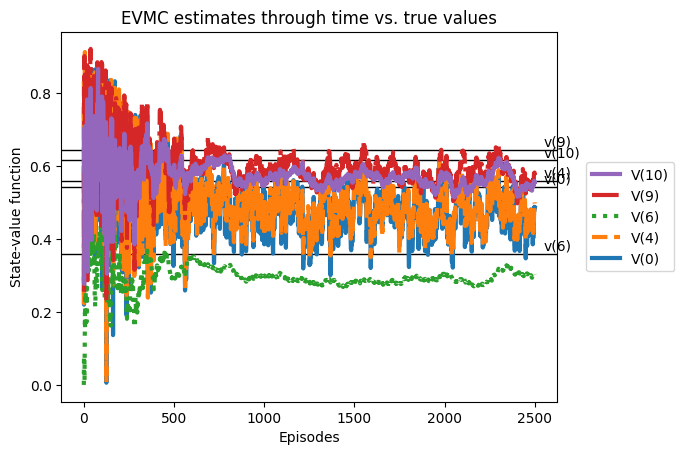

In [121]:
plot_value_function('EVMC estimates through time vs. true values', V_track_evmc, V_true, log=False)

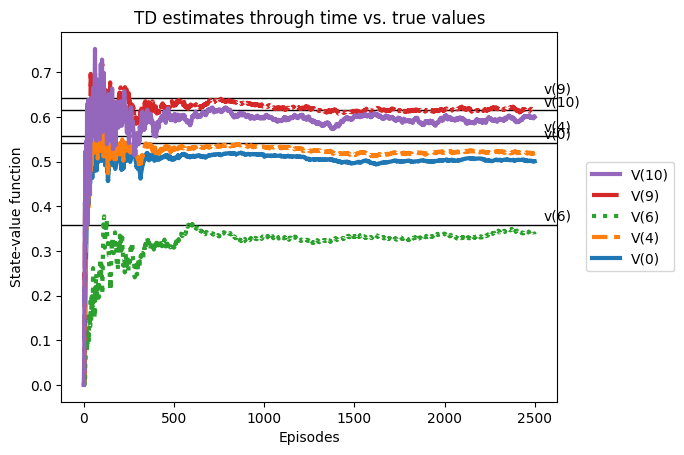

In [122]:
plot_value_function('TD estimates through time vs. true values', V_track_td, V_true, log=False)

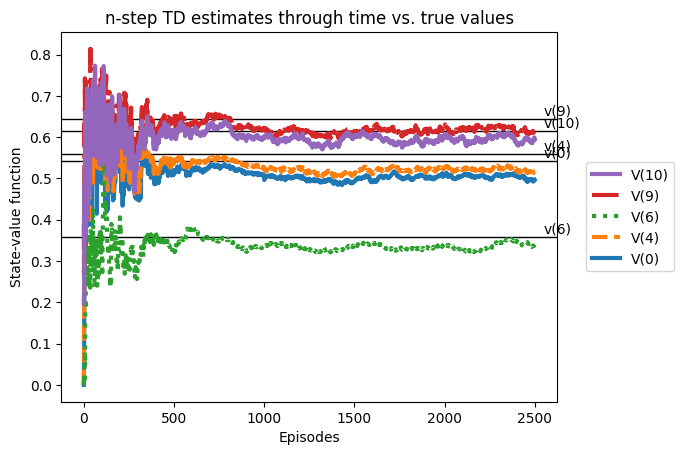

In [123]:
plot_value_function('n-step TD estimates through time vs. true values', V_track_ntd, V_true, log=False)

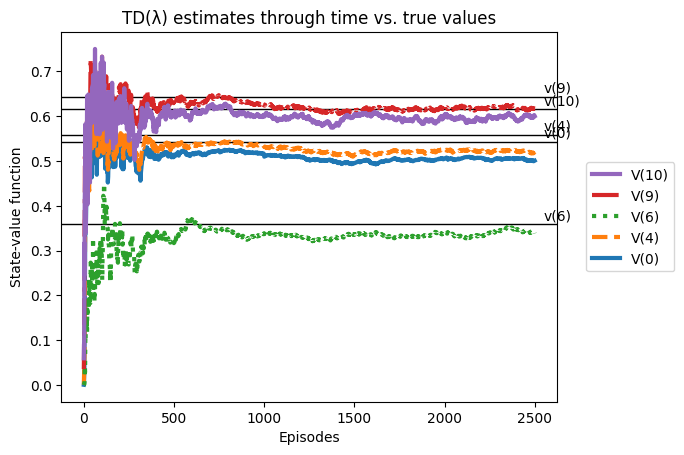

In [124]:
plot_value_function('TD(λ) estimates through time vs. true values', V_track_tdl, V_true, log=False)

### Plot state-value function estimation (log scale)

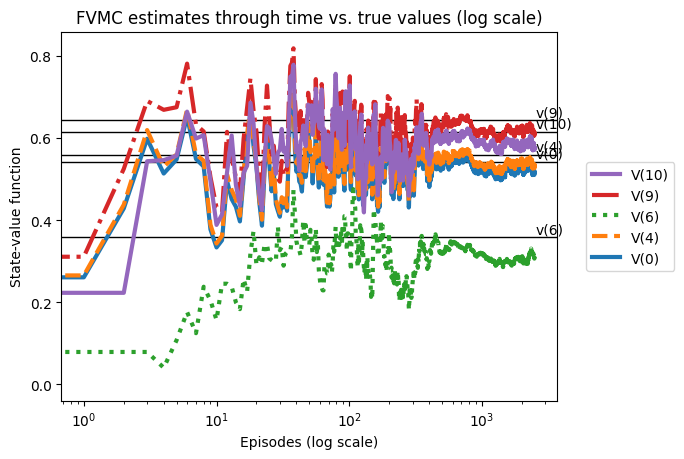

In [125]:
plot_value_function('FVMC estimates through time vs. true values (log scale)', V_track_fvmc, V_true, log=True)

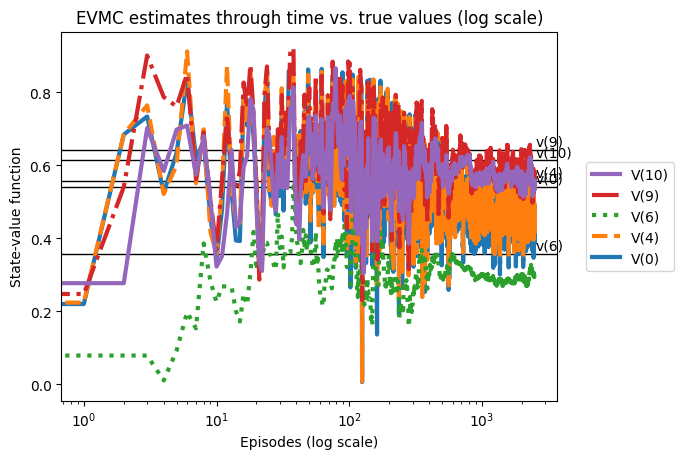

In [126]:
plot_value_function('EVMC estimates through time vs. true values (log scale)', V_track_evmc, V_true, log=True)

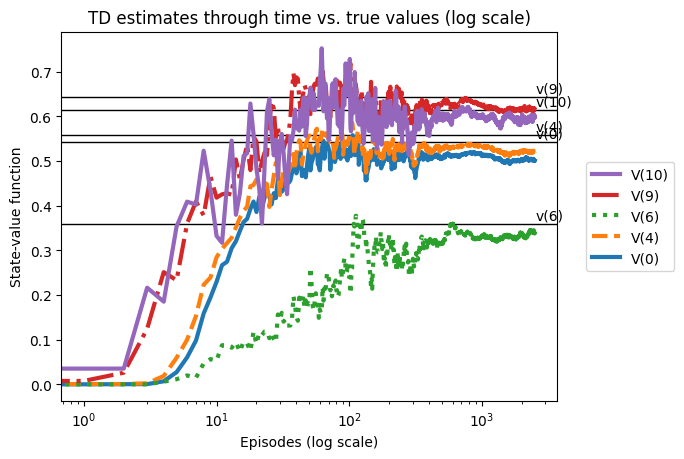

In [127]:
plot_value_function('TD estimates through time vs. true values (log scale)', V_track_td, V_true, log=True)

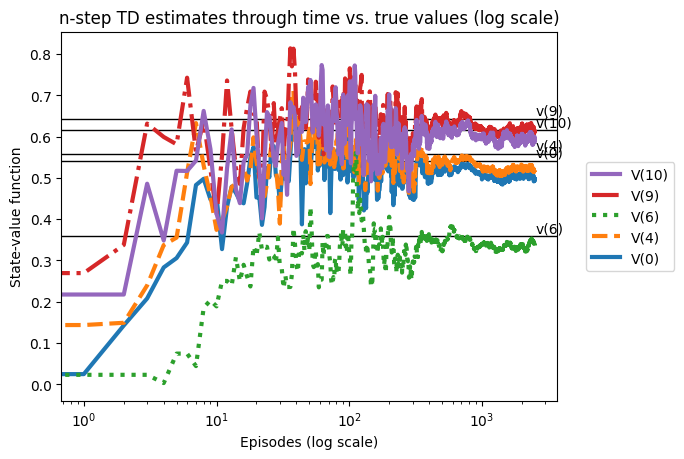

In [128]:
plot_value_function('n-step TD estimates through time vs. true values (log scale)', V_track_ntd, V_true, log=True)

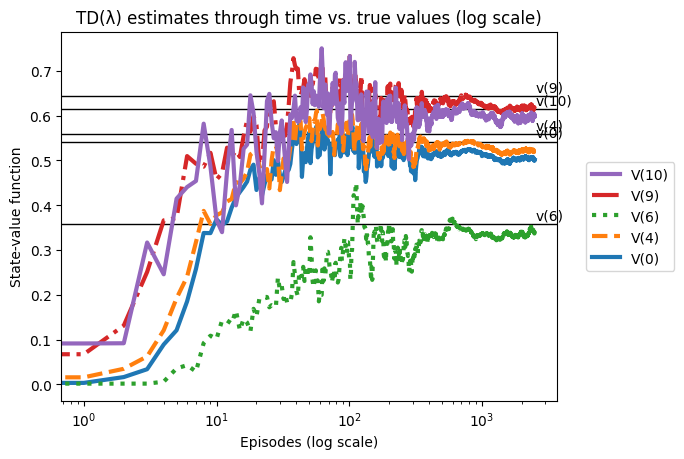

In [129]:
plot_value_function('TD(λ) estimates through time vs. true values (log scale)', V_track_tdl, V_true, log=True)

### Close Ups

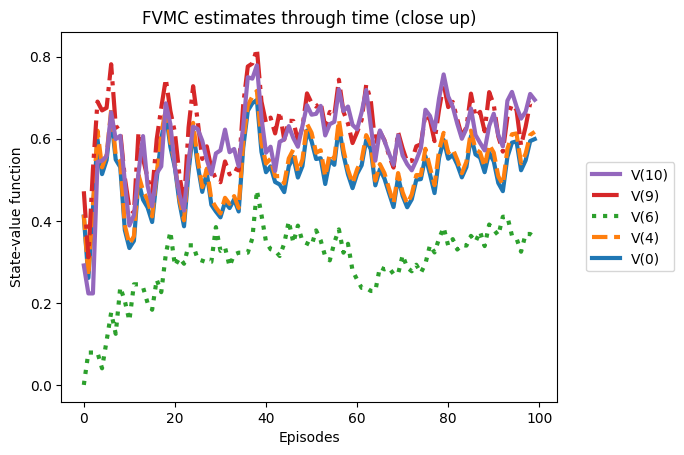

In [130]:
plot_value_function('FVMC estimates through time (close up)', V_track_fvmc[:100], None, log=False)

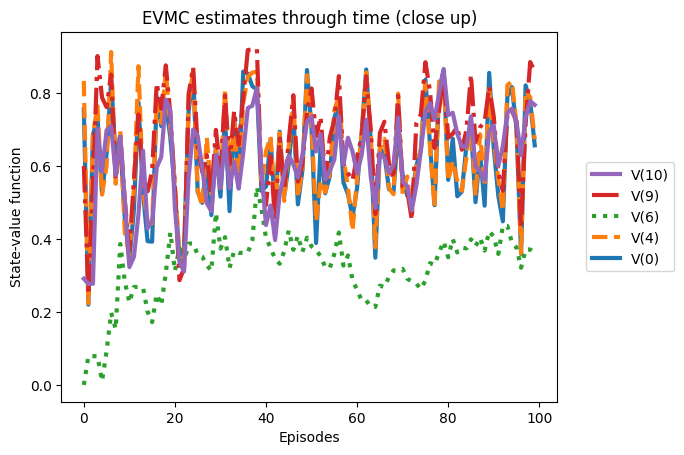

In [131]:
plot_value_function('EVMC estimates through time (close up)', V_track_evmc[:100], None, log=False)

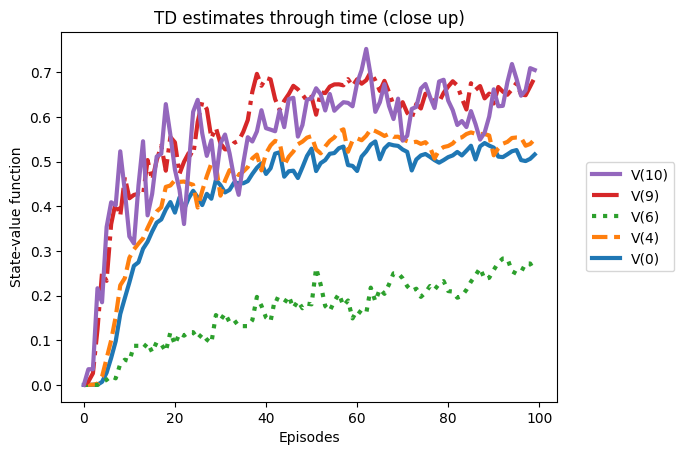

In [132]:
plot_value_function('TD estimates through time (close up)', V_track_td[:100], None, log=False)

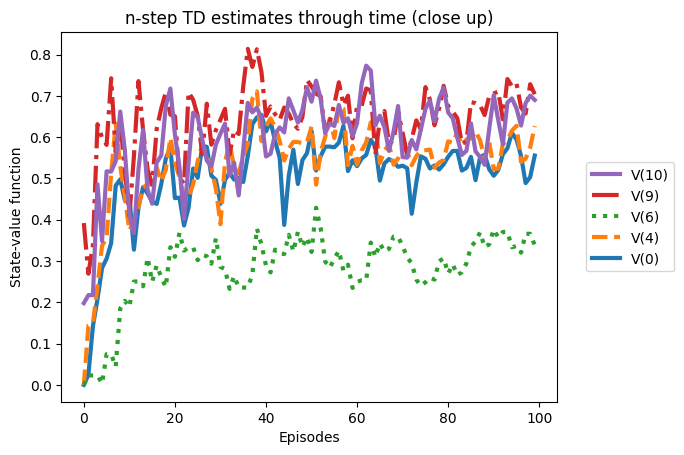

In [133]:
plot_value_function('n-step TD estimates through time (close up)', V_track_ntd[:100], None, log=False)

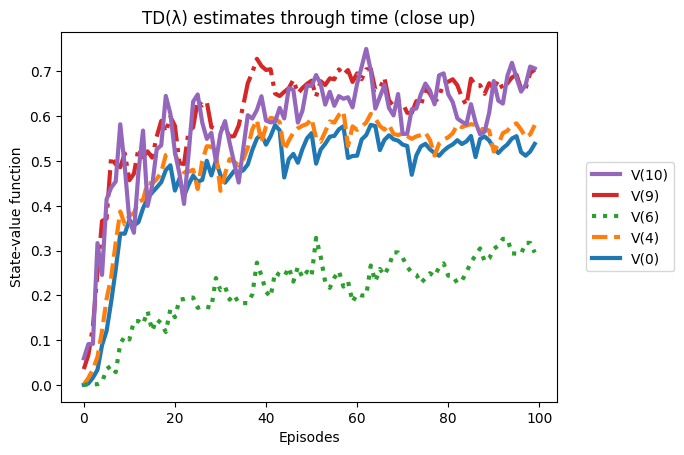

In [134]:
plot_value_function('TD(λ) estimates through time (close up)', V_track_tdl[:100], None, log=False)

### MC vs TD

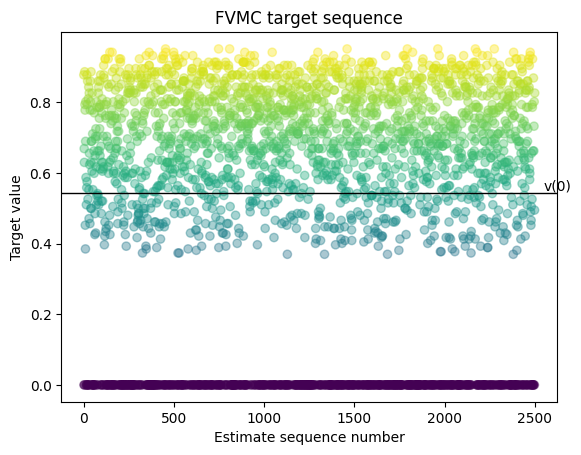

In [135]:
plot_targets(targets_fvmc, init_state, title='FVMC target sequence')

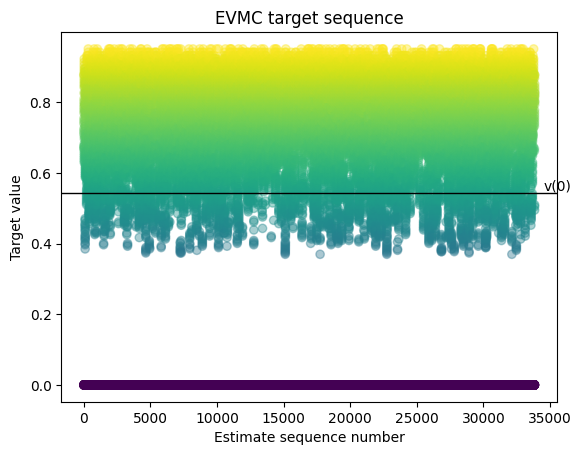

In [136]:
plot_targets(targets_evmc, init_state, title='EVMC target sequence')

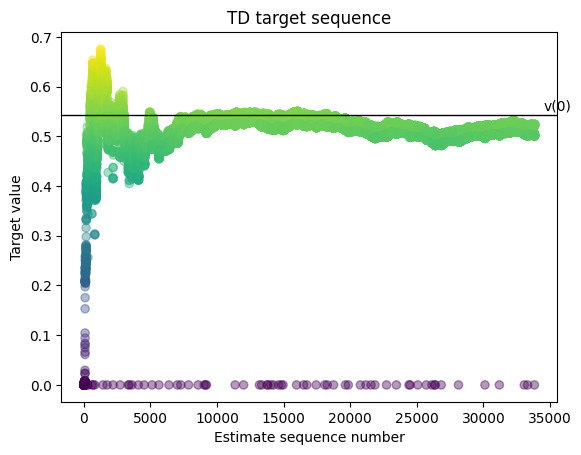

In [137]:
plot_targets(targets_td, init_state, title='TD target sequence')

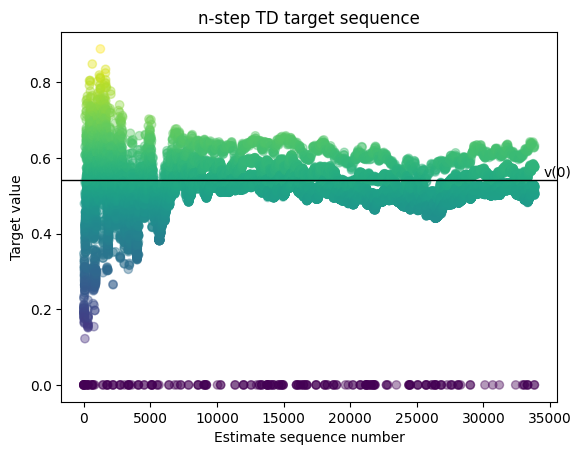

In [138]:
plot_targets(targets_ntd, init_state, title='n-step TD target sequence')

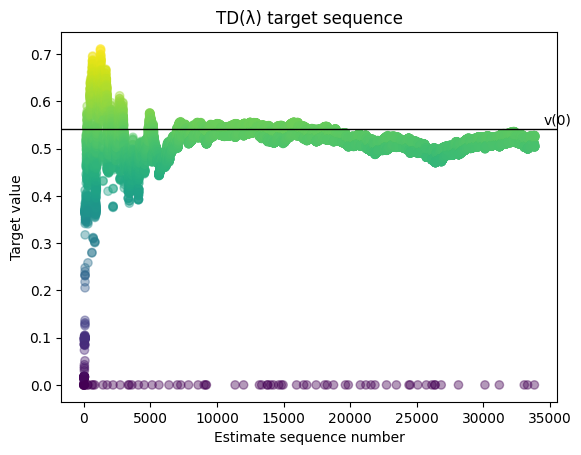

In [139]:
plot_targets(targets_tdl, init_state, title='TD(λ) target sequence')

# Improve Agent's Behaviour (Control)

**Control Problem** - Policy improvement; finding optimal policies, usually solved by following the pattern of Generalised Policy Iteration (GPI), where the competing processes of policy evaluation and policy improvement progressively move the policies to optimality.

## Utilities

In [175]:
# slightly modified from chapter 4: pi is a function instead of dict,
# also returns Q
def value_iteration(P, gamma=1.0, theta=1e-10):
  n_states = len(P)
  n_actions = len(P[0])
  # initialise V to zeros
  V = np.zeros(n_states, dtype=np.float64)

  while True:
    # initialise Q-function to zeros
    Q = np.zeros((n_states, n_actions), dtype=np.float64)
    for s in range(n_states):
      for a in range(n_actions):
        for prob, next_state, reward, done in P[s][a]:
          Q[s,a] += prob * (reward + gamma * V[next_state] * (not done))
    if np.max( np.abs(V - np.max(Q, axis=1)) ) < theta:
      break; # if the action-advantage function converged, break

    V = np.max(Q, axis=1) # combination of policy eval and improv
  #pi = {s:a for s, a in enumerate( np.argmax(Q, axis=1) )}
  pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]

  return Q, V, pi

# different version than the prediction problems above.
def generate_trajectory2(select_action, Q, epsilon, env, max_steps=200):
  done = False
  trajectory = []

  while not done:
    state = env.reset()
    for t in count(): # count is from itertool library: count up forever
      action = select_action(state, Q, epsilon)
      next_state, reward, done, _ = env.step(action)
      experience = (state, action, reward, next_state, done)
      trajectory.append(experience)
      if done:
        break
      # if the current trajectory did not reach a terminal state after maximum
      # steps allowed, then give up on current trajectory, try another one
      if t >= max_steps - 1:
        trajectory = []
        break
      state = next_state

  return np.array(trajectory, dtype=np.object_)

### Get Metrics

In [140]:
def get_policy_metrics(env, gamma, pi, goal_state, optimal_Q,
                       n_episodes=100, max_steps=200):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    reached_goal, episode_reward, episode_regret = [], [], []
    for _ in range(n_episodes):
        state, done, steps = env.reset(), False, 0
        episode_reward.append(0.0)
        episode_regret.append(0.0)
        while not done and steps < max_steps:
            action = pi(state)
            regret = np.max(optimal_Q[state]) - optimal_Q[state][action]
            episode_regret[-1] += regret

            state, reward, done, _ = env.step(action)
            episode_reward[-1] += (gamma**steps * reward)

            steps += 1

        reached_goal.append(state == goal_state)
    results = np.array((np.sum(reached_goal)/len(reached_goal)*100,
                        np.mean(episode_reward),
                        np.mean(episode_regret)))
    return results

def get_metrics_from_tracks(env, gamma, goal_state, optimal_Q, pi_track, coverage=0.1):
    total_samples = len(pi_track)
    n_samples = int(total_samples * coverage)
    samples_e = np.linspace(0, total_samples, n_samples, endpoint=True, dtype=np.int)
    metrics = []
    for e, pi in enumerate(tqdm(pi_track)):
        if e in samples_e:
            metrics.append(get_policy_metrics(
                env,
                gamma=gamma,
                pi=lambda s: pi[s],
                goal_state=goal_state,
                optimal_Q=optimal_Q))
        else:
            metrics.append(metrics[-1])
    metrics = np.array(metrics)
    success_rate_ma, mean_return_ma, mean_regret_ma = np.apply_along_axis(moving_average, axis=0, arr=metrics).T
    return success_rate_ma, mean_return_ma, mean_regret_ma

In [141]:
def moving_average(a, n=100) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

### Alpha & Epsilon schedules

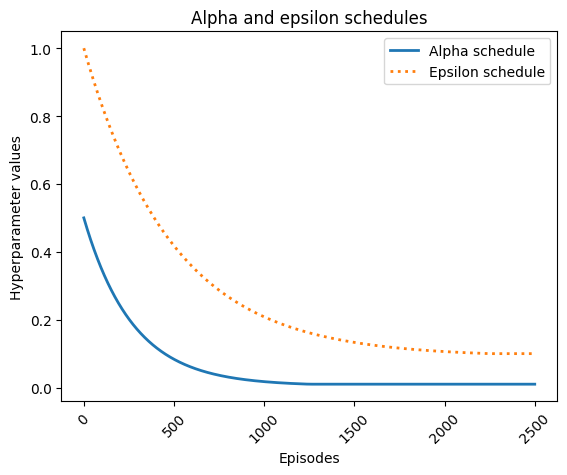

In [142]:
plt.plot(decay_schedule(0.5, 0.01, 0.5, n_episodes),
         '-', linewidth=2,
         label='Alpha schedule')
plt.plot(decay_schedule(1.0, 0.1, 0.9, n_episodes),
         ':', linewidth=2,
         label='Epsilon schedule')
plt.legend(loc=1, ncol=1)

plt.title('Alpha and epsilon schedules')
plt.xlabel('Episodes')
plt.ylabel('Hyperparameter values')
plt.xticks(rotation=45)

plt.show()

## Slippery Walk 7 Environment

This env has 7 non-terminal states, 2 terminal states (one at each end). It's a slippery walk:
* 50% chance of going intended direction
* 33.3% chance of staying put
* 16.6% chance of going the opposite direction

In [143]:
env = gym.make('SlipperyWalkSeven-v0')
init_state = env.reset()
goal_state = 8
gamma = 0.99
n_episodes = 3000
P = env.env.P
n_cols, svf_prec, err_prec, avf_prec=9, 4, 2, 3
action_symbols=('<', '>')
limit_items, limit_value = 5, 0.0
cu_limit_items, cu_limit_value, cu_episodes = 10, 0.0, 100

In [150]:
env.render()


[ABCDEFG]


Optimal Value function and Policy

In [149]:
optimal_Q, optimal_V, optimal_pi = value_iteration(P, gamma=gamma)
print_state_value_function(optimal_V, P, n_cols=n_cols, prec=svf_prec, title='Optimal state-value function:')
print()

print_action_value_function(optimal_Q,
                            None,
                            action_symbols=action_symbols,
                            prec=avf_prec,
                            title='Optimal action-value function:')
print()
print_policy(optimal_pi, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_op, mean_return_op, mean_regret_op = get_policy_metrics(
    env, gamma=gamma, pi=optimal_pi, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_op, mean_return_op, mean_regret_op))

Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |

Optimal action-value function:
╒═════╤═══════╤═══════╕
│   s │     < │     > │
╞═════╪═══════╪═══════╡
│   0 │ 0     │ 0     │
├─────┼───────┼───────┤
│   1 │ 0.312 │ 0.564 │
├─────┼───────┼───────┤
│   2 │ 0.67  │ 0.763 │
├─────┼───────┼───────┤
│   3 │ 0.803 │ 0.845 │
├─────┼───────┼───────┤
│   4 │ 0.864 │ 0.889 │
├─────┼───────┼───────┤
│   5 │ 0.901 │ 0.922 │
├─────┼───────┼───────┤
│   6 │ 0.932 │ 0.952 │
├─────┼───────┼───────┤
│   7 │ 0.961 │ 0.981 │
├─────┼───────┼───────┤
│   8 │ 0     │ 0     │
╘═════╧═══════╧═══════╛

Policy:
|           | 01      > | 02      > | 03      > | 04      > | 05      > | 06      > | 07      > |           |
Reaches goal 96.00%. Obtains an average return of 0.8672. Regret of 0.0000


## Monte-Carlo Control (offline)

Improving policies after each episode (offline update).
* use MC Prediction for policy evaluation
* use decaying e-greedy for action selection strategy (policy improvement)

In [181]:
def mc_control(env,
               gamma=1.0,
               init_alpha=0.5, min_alpha=0.01, alpha_decay_ratio=0.5,
               init_epsilon=1.0, min_epsilon=0.1, epsilon_decay_ratio=0.9,
               n_episodes=3000,
               max_steps=200,
               first_visit=True
               ):
  nS, nA = env.observation_space.n, env.action_space.n

  # calculate all discount factors in advance; note: use max_steps because it's
  # the max length of the trajectory
  discounts = np.logspace(0, max_steps, num=max_steps, base=gamma, endpoint=False)

  # calculate all alphas in advance
  alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)

  # calculate all epsilons in advance
  epsilons = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes)

  # initialise variables:
  pi_track = []
  Q = np.zeros((nS, nA), dtype=np.float32)
  Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float32)
  # eps-greedy, return (action) index of Q[state]
  select_action = lambda state, Q, epsilon: \
    np.argmax(Q[state]) if np.random.random() > epsilon \
    else np.random.randint(len(Q[state]))

  for e in tqdm(range(n_episodes), leave=False):
    trajectory = generate_trajectory2(select_action, Q, epsilons[e], env, max_steps)
    visited = np.zeros((nS, nA), dtype=np.bool_) # keep track of visited state-action pairs
    # notice we project trajectory offline - i.e. after interaction with env is stopped
    for t, (state, action, reward, _, _) in enumerate(trajectory):
      # if FV algo, then we only update on first-visit, i.e. skip subsequent ones
      if visited[state][action] and first_visit:
        continue
      visited[state][action] = True

      n_steps = len(trajectory[t:]) # num steps from t:T
      G = np.sum(discounts[:n_steps] * trajectory[t:, 2]) # 3rd element of experience is reward
      Q[state][action] = Q[state][action] + alphas[e]*(G - Q[state][action])

    Q_track[e] = Q
    pi_track.append(np.argmax(Q, axis=1)) # axis=1 is action

  V = np.max(Q, axis=1)
  pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]

  return Q, V, pi, Q_track, pi_track

In [183]:
Q_mcs, V_mcs, Q_track_mcs = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
  random.seed(seed); np.random.seed(seed) ; env.seed(seed)
  Q_mc, V_mc, pi_mc, Q_track_mc, pi_track_mc = mc_control(env, gamma=gamma, n_episodes=n_episodes)
  Q_mcs.append(Q_mc) ; V_mcs.append(V_mc) ; Q_track_mcs.append(Q_track_mc)
Q_mc, V_mc, Q_track_mc = np.mean(Q_mcs, axis=0), np.mean(V_mcs, axis=0), np.mean(Q_track_mcs, axis=0)
del Q_mcs ; del V_mcs ; del Q_track_mcs

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [184]:
print_state_value_function(V_mc, P, n_cols=n_cols,
                           prec=svf_prec, title='State-value function found by FVMC:')
print_state_value_function(optimal_V, P, n_cols=n_cols,
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_mc - optimal_V, P, n_cols=n_cols,
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_mc, optimal_V)))
print()
print_action_value_function(Q_mc,
                            optimal_Q,
                            action_symbols=action_symbols,
                            prec=avf_prec,
                            title='FVMC action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_mc, optimal_Q)))
print()
print_policy(pi_mc, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_mc, mean_return_mc, mean_regret_mc = get_policy_metrics(
    env, gamma=gamma, pi=pi_mc, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_mc, mean_return_mc, mean_regret_mc))

State-value function found by FVMC:
|           | 01 0.5019999742507935 | 02 0.7282000184059143 | 03 0.8219000101089478 | 04 0.8734999895095825 | 05 0.9146000146865845 | 06 0.9456999897956848 | 07 0.9797000288963318 |           |
Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |
State-value function errors:
|           | 01  -0.06 | 02  -0.03 | 03  -0.02 | 04  -0.02 | 05  -0.01 | 06  -0.01 | 07   -0.0 |           |
State-value function RMSE: 0.0256

FVMC action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤════════╤════════╕
│   s │     < │     > │   * < │   * > │   er < │   er > │
╞═════╪═══════╪═══════╪═══════╪═══════╪════════╪════════╡
│   0 │ 0     │ 0     │ 0     │ 0     │  0     │  0     │
├─────┼───────┼───────┼───────┼───────┼────────┼────────┤
│   1 │ 0.175 │ 0.502 │ 0.312 │ 0.564 │  0.137 │  0.062 │
├─────┼───────┼───────┼───────┼───────┼────────┼────────┤
│   2 │ 0.557 │ 0.728 

## Sarsa (online)

Improving policies after each step (online):
* use (truncated) TD prediction for Policy Evaluation phase
* use decaying e-Greedy for action selection strategy (policy improvement).

In [ ]:
# modified from TD function: evaluate Q instead of V; add policy improvemen step
def sarsa(env, gamma=1.0,
          init_alpha=0.5, min_alpha=0.01, alpha_decay_ratio=0.5,
          init_epsilon=1.0, min_epsilon=0.1, epsilon_decay_ratio=0.9,
          n_episodes=3000):
  nS = env.observation_space.n
  nA = env.action_space.n
  pi_track = []
  Q = np.zeros((nS, nA), dtype=np.float32)
  Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float32)
  select_action = lambda state, Q, epsilon: \
    np.argmax(Q[state]) if np.random.random() > epsilon \
    else np.random.randint(len(Q[state])
  alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
  epsilons = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes)

  for e in tqdm(range(n_episodes), leave=False):
    state = env.reset()
    done = False
    action = select_action(state, Q, epsilon[e])
    while not done:
      next_state, reward, done, _ = env.step(action)
      next_action = select_action(next_state, Q, epsilon[e])
      td_target = reward + gamma * Q[next_state][next_action] * (not done)
      td_error = td_target - Q[state][action]
      Q[state][action] = Q[state][action] + alphas[e] * td_error
      state, action = next_state, next_action

    Q_track[e] = Q
    pi_track.append(np.argmax(Q, axis=1)) # axis 1 is action
  V = np.max(Q, axis=1)
  pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]

  return Q, V, pi, Q_track, pi_track

## Q-Learning

A model-free off-policy bootstrapping method that directly approximates the optimal policy (agent can act randomly and can still find optimal value function and policy).